In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import rescomp

import matplotlib.pyplot as plt
# import pyfftw

In [2]:
import sys
sys.executable

'C:\\Users\\Dennis\\anaconda3\\envs\\rc_env_np16p6\\python.exe'

# Check the LE spectrum for different KS Simulations:

In [3]:
def create_ks_sim_func(fft_type, prec, dimensions, system_size, mode="normal"):
    if mode == "precision":
        def data_creation_function(time_steps, dt, starting_point=None):
            return rescomp.simulations._kuramoto_sivashinsky_custom(dimensions, system_size, dt, time_steps, starting_point,
                                     precision=prec, fft_type=fft_type)
    elif mode == "Bhatt":
        def data_creation_function(time_steps, dt, starting_point=None):
            return rescomp.simulations._kuramoto_sivashinsky_Bhatt(dimensions, system_size, dt, time_steps, starting_point)
    elif mode == "normal":
        def data_creation_function(time_steps, dt, starting_point=None):
            return rescomp.simulations._kuramoto_sivashinsky(dimensions, system_size, dt, time_steps, starting_point)
    
    return data_creation_function

# Create different KS Sim functions:
def create_ks_sim_dict(dimensions, system_size):
    ks_sim_dict = {
                   "scipy32": create_ks_sim_func("scipy", 32, dimensions, system_size, mode="precision"), 
                   "scipy64": create_ks_sim_func("scipy", 64, dimensions, system_size, mode="precision"), 
                   "scipy": create_ks_sim_func("scipy",None, dimensions, system_size, mode="precision"),
                   "numpy32": create_ks_sim_func("numpy",32, dimensions, system_size, mode="precision"), 
                   "numpy64": create_ks_sim_func("numpy",64, dimensions, system_size, mode="precision"),
                   "numpy": create_ks_sim_func("numpy",None, dimensions, system_size, mode="precision"),
                   "normal": create_ks_sim_func(None, None, dimensions, system_size, mode="normal"), 
                   "Bhatt": create_ks_sim_func(None, None, dimensions, system_size, mode="Bhatt")}
    return ks_sim_dict

In [4]:
# (2019) Edson, Bunder et al.
LE_literature_dict = {12: [0.003, -0.005, -0.088, -0.089, -0.186, -3.524, -3.525, -9.835, -9.849, -9.959, -10.01, -10.12], 
                     13.5: [0.059, 0.004, -0.004, -0.227, -0.730, -1.467, -1.529, -6.956, -6.963, -7.977, -7.993, -9.199],
                     22: [0.043, 0.003, 0.002, -0.004, -0.008, -0.185, -0.253, -0.296, -0.309, -1.965, -1.967, -5.599], 
                     36: [0.080, 0.056, 0.014, 0.003, -0.003, -0.004, -0.021, -0.088, -0.160, -0.224, -0.309, -0.373], 
                     60: [0.089, 0.067, 0.055, 0.041, 0.030, 0.005, 0.003, 0.000, -0.004, -0.009, -0.029, -0.066],
                     100: [0.088, 0.082, 0.070, 0.061, 0.048, 0.041, 0.033, 0.028, 0.018, 0.012, 0.005, 0.003]}

### 1. Check the trajectories for different KS simulations:

In [72]:
dt = 0.25
system_size = 36 # 12, 13.5, 22, 36, 60, 100
ratio_dim_to_L = 1.5
dimensions = int(system_size*ratio_dim_to_L)
if dimensions%2 == 1: # for the fft KS sims, the dimension has to be even
    dimensions += 1 
print(f"dimensions={dimensions}")

time = 1000
time_steps = int(time/dt)
KS_sims = ["normal", "Bhatt", "scipy", "scipy32", "scipy64", "numpy", "numpy32", "numpy64"]
np.random.seed(1)
starting_point = np.random.randn(dimensions)

ks_sim_dict = create_ks_sim_dict(dimensions, system_size)

dimensions=54


In [73]:
results_traj = {}
for key in KS_sims:
    data_creation_function = ks_sim_dict[key]
    results = data_creation_function(time_steps, dt, starting_point=starting_point)
    results_traj[key] = results

Text(0.5, 0, 'time_steps')

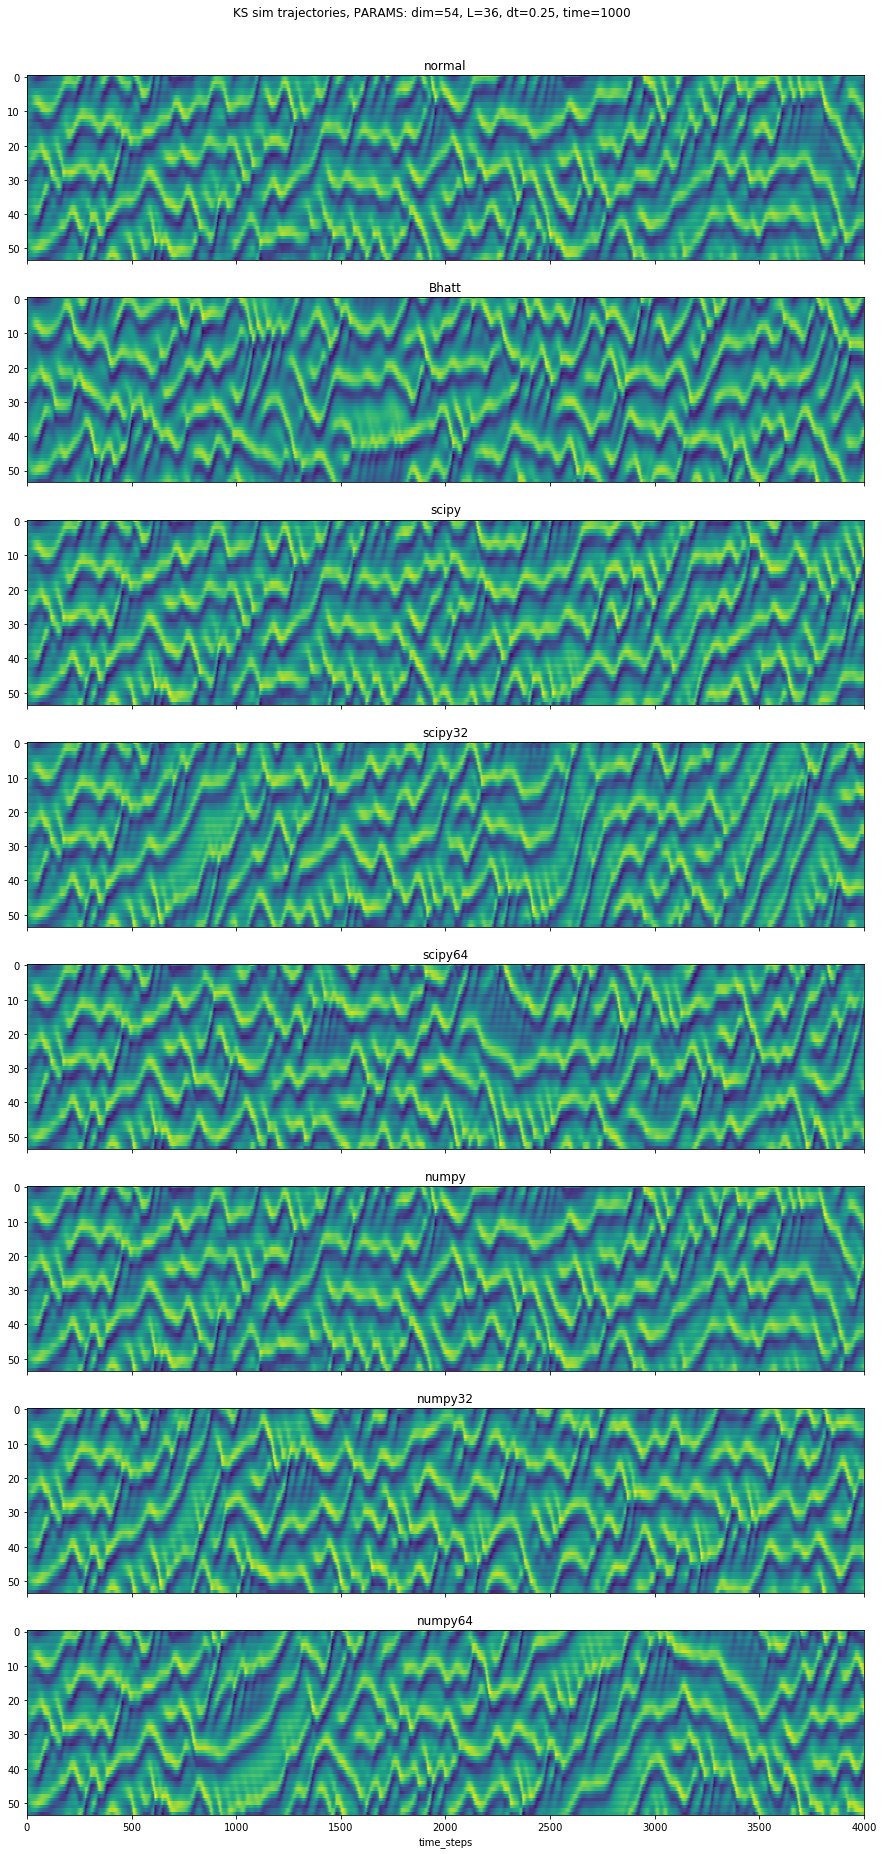

In [75]:
# PLOTTING
fig, axs = plt.subplots(len(results_traj), 1, figsize=(15,4*len(results_traj)), sharex=True)
plt.suptitle(f"KS sim trajectories, PARAMS: dim={dimensions}, L={system_size}, dt={dt}, time={time}"
             , y = 0.91)
i = 0
for key, res in results_traj.items():
    try:
        ax = axs[i]
    except:
        ax = axs
    ax.set_title(key)
    ax.imshow(res.T, aspect="auto")
    
    i+=1
ax.set_xlabel("time_steps")

### 2. Check development trajectories for one Parameter set: 

In [204]:
np.random.seed(1)

# PARAMETERS
dt = 0.25
N = 100
tau = 100
T = 2
eps = 1e-6
m = 5
system_size = 100 # 12, 13.5, 22, 36, 60, 100

ratio_dim_to_L = 1.5
dimensions = int(system_size*ratio_dim_to_L)
if dimensions%2 == 1: # for the fft KS sims, the dimension has to be even
    dimensions += 1 
print(f"dimensions={dimensions}")

# dimensions = 39
N_ens = 3

KS_sims = ["normal", "Bhatt", "scipy", "scipy32", "scipy64", "numpy", "numpy32", "numpy64"]
# KS_sims = ["normal", "Bhatt", "scipy32"]
# KS_sims = ["Bhatt", ]


starting_points = np.random.randn(N_ens, dimensions)

# LITERATURE VALUES:
# lyapunov_exp_literature = [0.08, 0.056, 0.014, 0.003, -0.003, -0.004, -0.021, -0.088, -0.160, -0.224, -0.309, -0.373]
lyapunov_exp_literature = LE_literature_dict[system_size]

dimensions=150


In [206]:
results_LE_dev = {}
ks_sim_dict = create_ks_sim_dict(dimensions, system_size)
for key in KS_sims:
    data_creation_function = ks_sim_dict[key]
    print(f"ks sim type: {key}")
    results = np.zeros((N_ens, N, m))
    for i in range(N_ens):
        starting_point = starting_points[i, :]
        def f(x):
            return data_creation_function(time_steps=2, dt=dt, starting_point=x)[-1]
        out = rescomp.measures.iterator_based_lyapunov_spectrum(f, starting_point=starting_point, 
                                                                T=T, tau=tau, eps=eps, 
                                                                nr_steps=N, dt=dt, return_convergence=True, 
                                                                nr_of_lyapunovs=m)
        results[i, :, :] = out[1]
        results_LE_dev[key] = results

ks sim type: normal
ks sim type: Bhatt
ks sim type: scipy
ks sim type: scipy32
ks sim type: scipy64
ks sim type: numpy
ks sim type: numpy32
ks sim type: numpy64


Text(0.5, 0, 'iterations of QR algorithm')

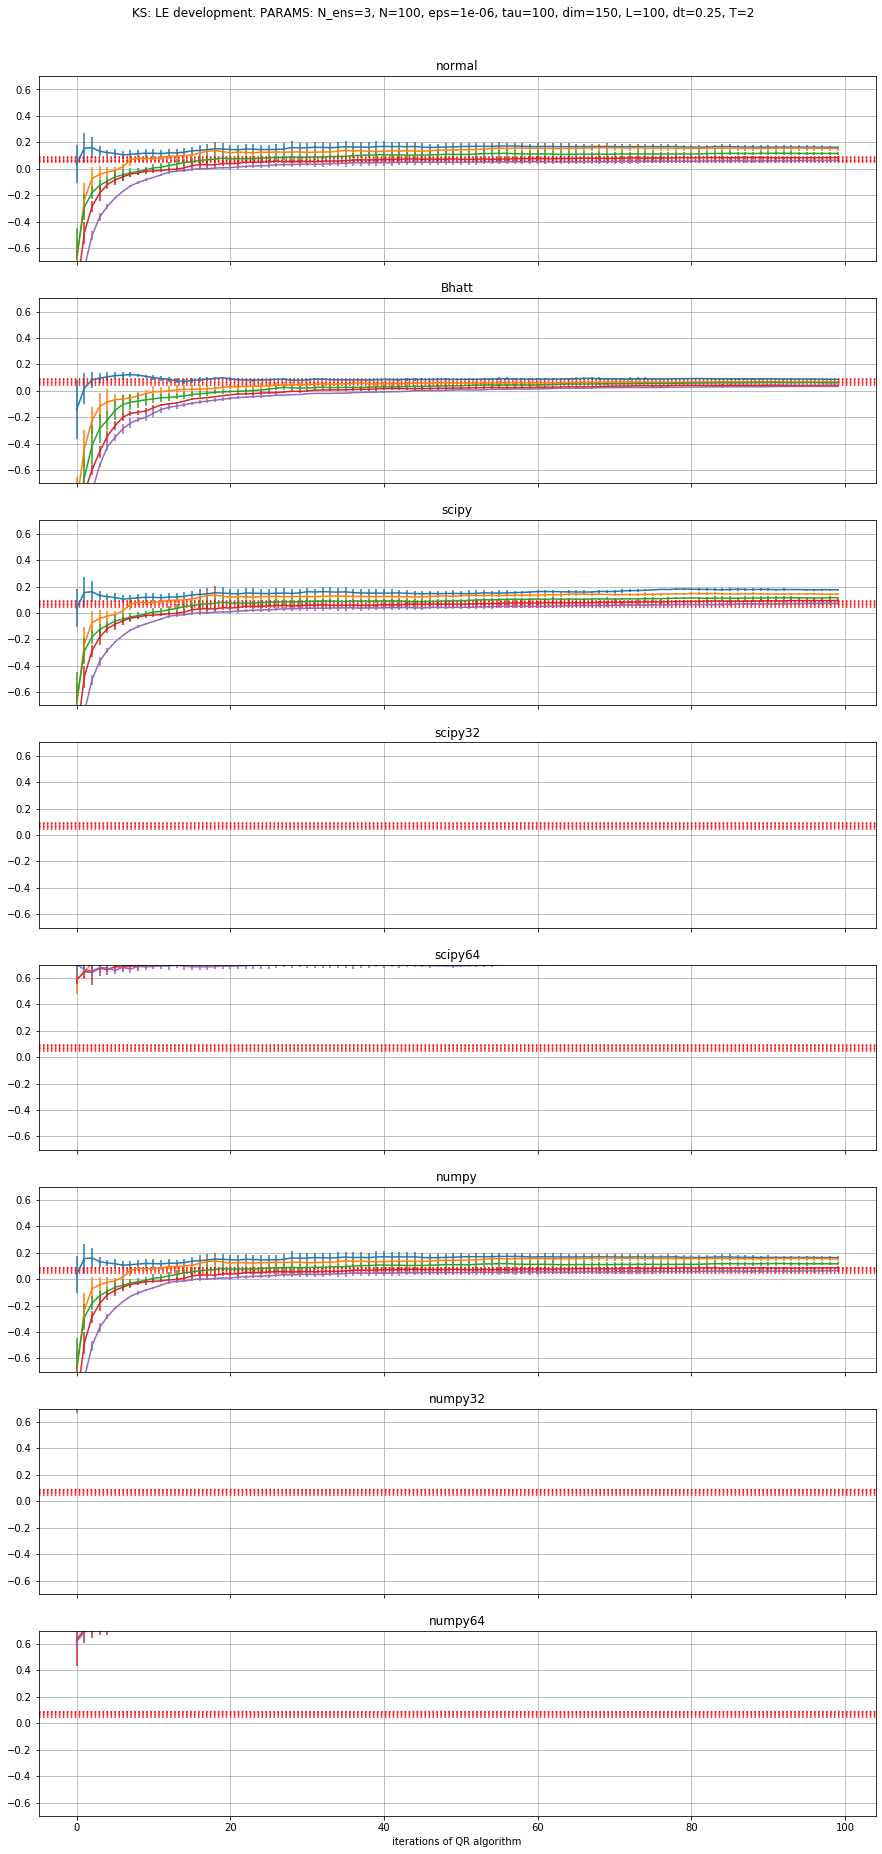

In [207]:
# PLOTTING
fig, axs = plt.subplots(len(results_LE_dev), 1, figsize=(15,4*len(results_LE_dev)), sharex=True)
plt.suptitle(f"KS: LE development. PARAMS: N_ens={N_ens}, N={N}, eps={eps}, tau={tau}, dim={dimensions}, L={system_size}, dt={dt}, T={T}"
             , y = 0.91)
i = 0
for key, res in results_LE_dev.items():
    try:
        ax = axs[i]
    except:
        ax = axs
    ax.set_title(key)
    ax.grid()
    avg = res.mean(axis=0)
    error = res.std(axis=0)
    for dim in range(m):
        ax.errorbar(x=np.arange(N), y=avg[:, dim], yerr=error[:, dim])
    for j, y in enumerate(lyapunov_exp_literature):
        if j == 0:
            ax.axhline(y, c="r", linestyle=":", label="literature")
        else:
            ax.axhline(y, c="r", linestyle=":")
        if j+1 == m:
            break
    ax.set_ylim(-0.7, 0.7)
    i+=1
ax.set_xlabel("iterations of QR algorithm")

# 2. Parameter sweep:


### version 2 (automatically save figs)

In [5]:
# Hypersweep:
taus = [100, 10000]
system_sizes = [12, 13.5, 22, 36, 60, 100]

# PARAMETERS

N = 100
eps = 1e-6
m = 5
ratio_dim_to_L = 1.5
N_ens = 3

# SWEEP
Ts = [1, 2, 5, 8]
dts= [0.1, 0.25]
KS_sims = ["normal", "Bhatt"]

# ############### testing
# # Hypersweep:
# taus = [10, 20]
# system_sizes = [12, 13.5, 22, 36, 60, 100]

# np.random.seed(1)

# # PARAMETERS

# N = 2
# eps = 1e-6
# m = 5
# ratio_dim_to_L = 1.5
# N_ens = 1

# # SWEEP
# Ts = [1, 2]
# dts= [0.25, 0.5]
# KS_sims = ["normal", "Bhatt"]
# ################ end testing

system_size=12
tau=100
dimensions=18
KS_sim: normal
dt: 0.1
dt: 0.25
KS_sim: Bhatt
dt: 0.1
dt: 0.25
tau=10000
dimensions=18
KS_sim: normal
dt: 0.1
dt: 0.25
KS_sim: Bhatt
dt: 0.1
dt: 0.25
system_size=13.5
tau=100
dimensions=20
KS_sim: normal
dt: 0.1
dt: 0.25
KS_sim: Bhatt
dt: 0.1
dt: 0.25
tau=10000
dimensions=20
KS_sim: normal
dt: 0.1
dt: 0.25
KS_sim: Bhatt
dt: 0.1
dt: 0.25
system_size=22
tau=100
dimensions=34
KS_sim: normal
dt: 0.1
dt: 0.25
KS_sim: Bhatt
dt: 0.1
dt: 0.25
tau=10000
dimensions=34
KS_sim: normal
dt: 0.1
dt: 0.25
KS_sim: Bhatt
dt: 0.1
dt: 0.25
system_size=36
tau=100
dimensions=54
KS_sim: normal
dt: 0.1
dt: 0.25
KS_sim: Bhatt
dt: 0.1
dt: 0.25
tau=10000
dimensions=54
KS_sim: normal
dt: 0.1
dt: 0.25
KS_sim: Bhatt
dt: 0.1
dt: 0.25
system_size=60
tau=100
dimensions=90
KS_sim: normal
dt: 0.1
dt: 0.25
KS_sim: Bhatt
dt: 0.1
dt: 0.25
tau=10000
dimensions=90
KS_sim: normal
dt: 0.1
dt: 0.25
KS_sim: Bhatt
dt: 0.1
dt: 0.25
system_size=100
tau=100
dimensions=150
KS_sim: normal
dt: 0.1
d

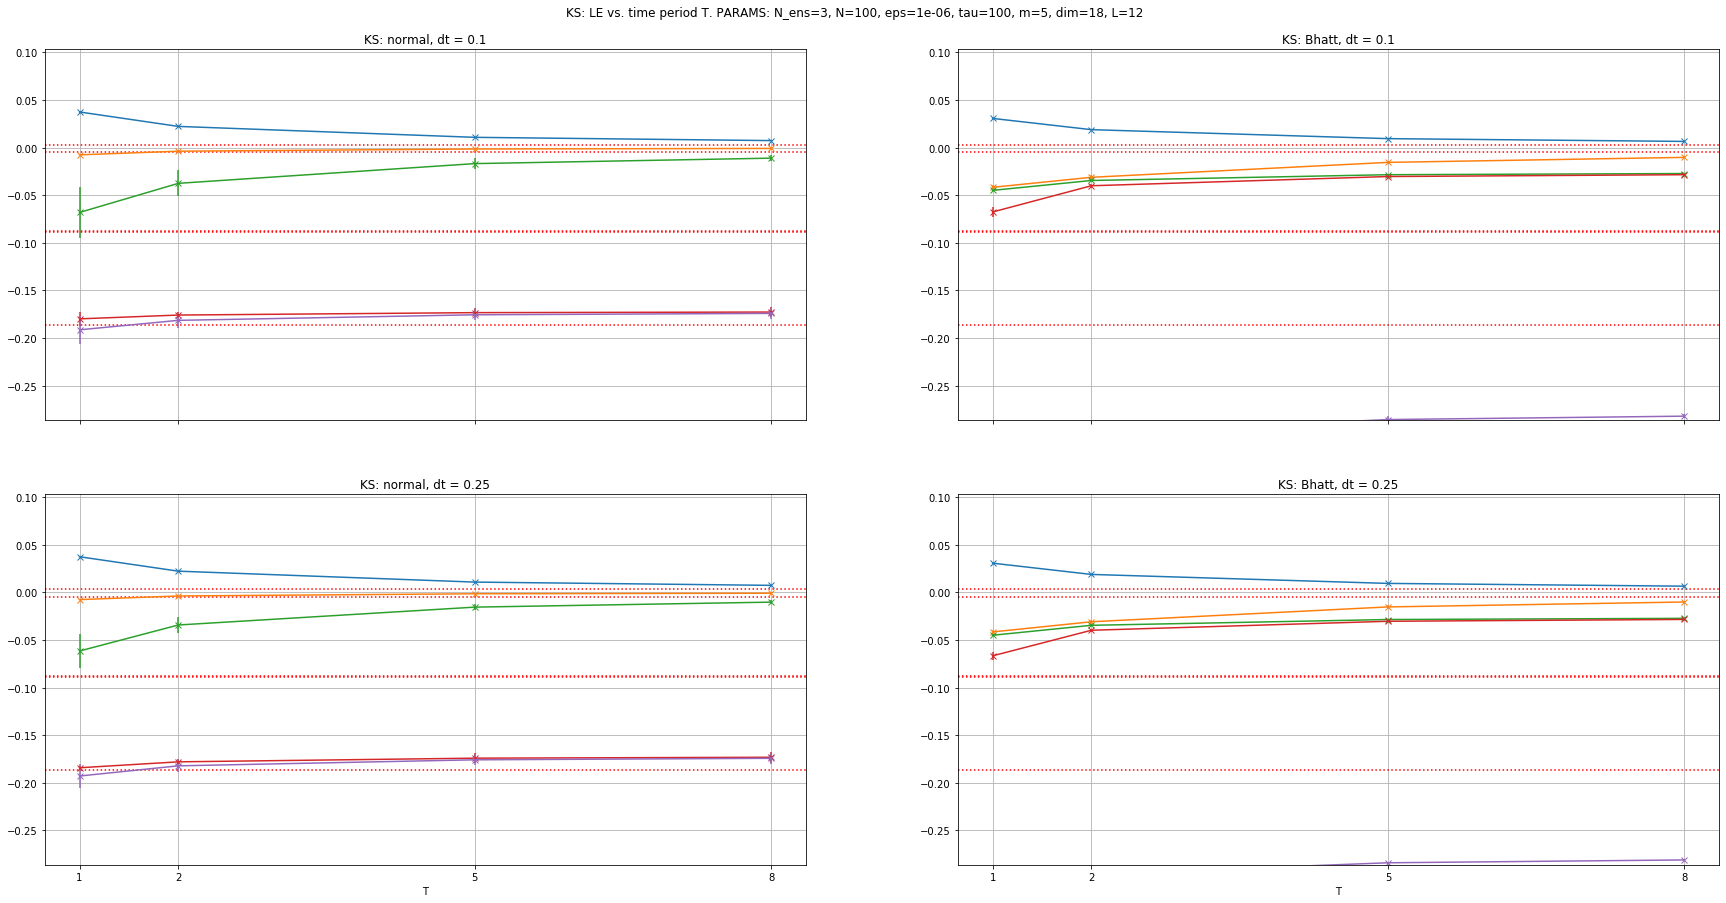

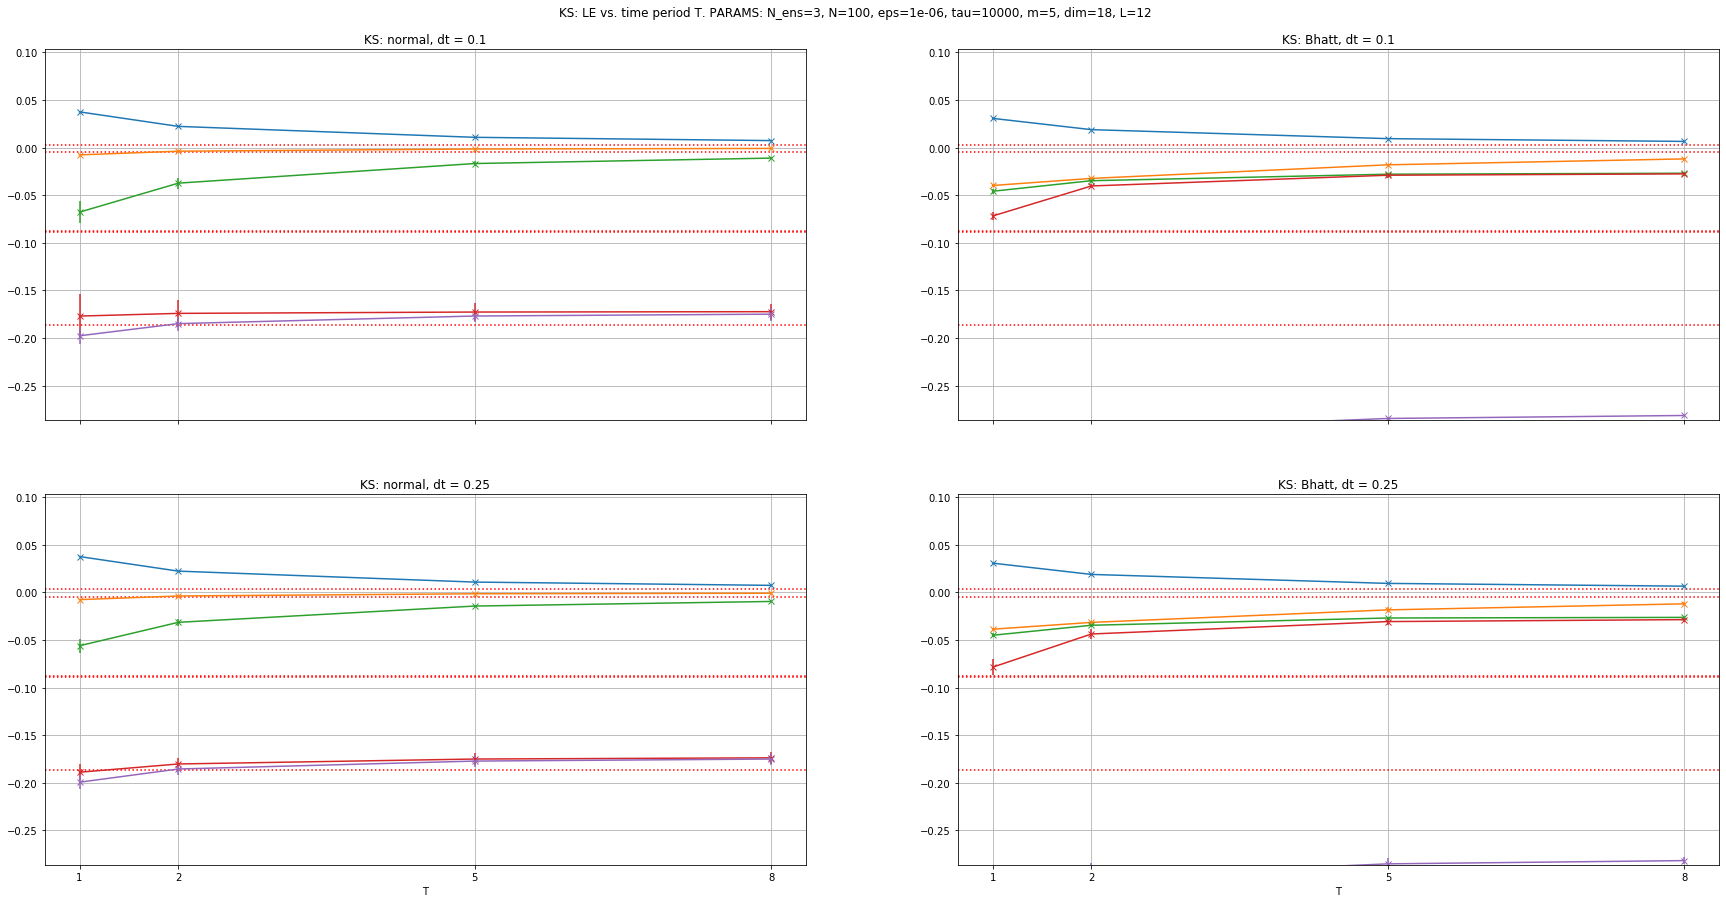

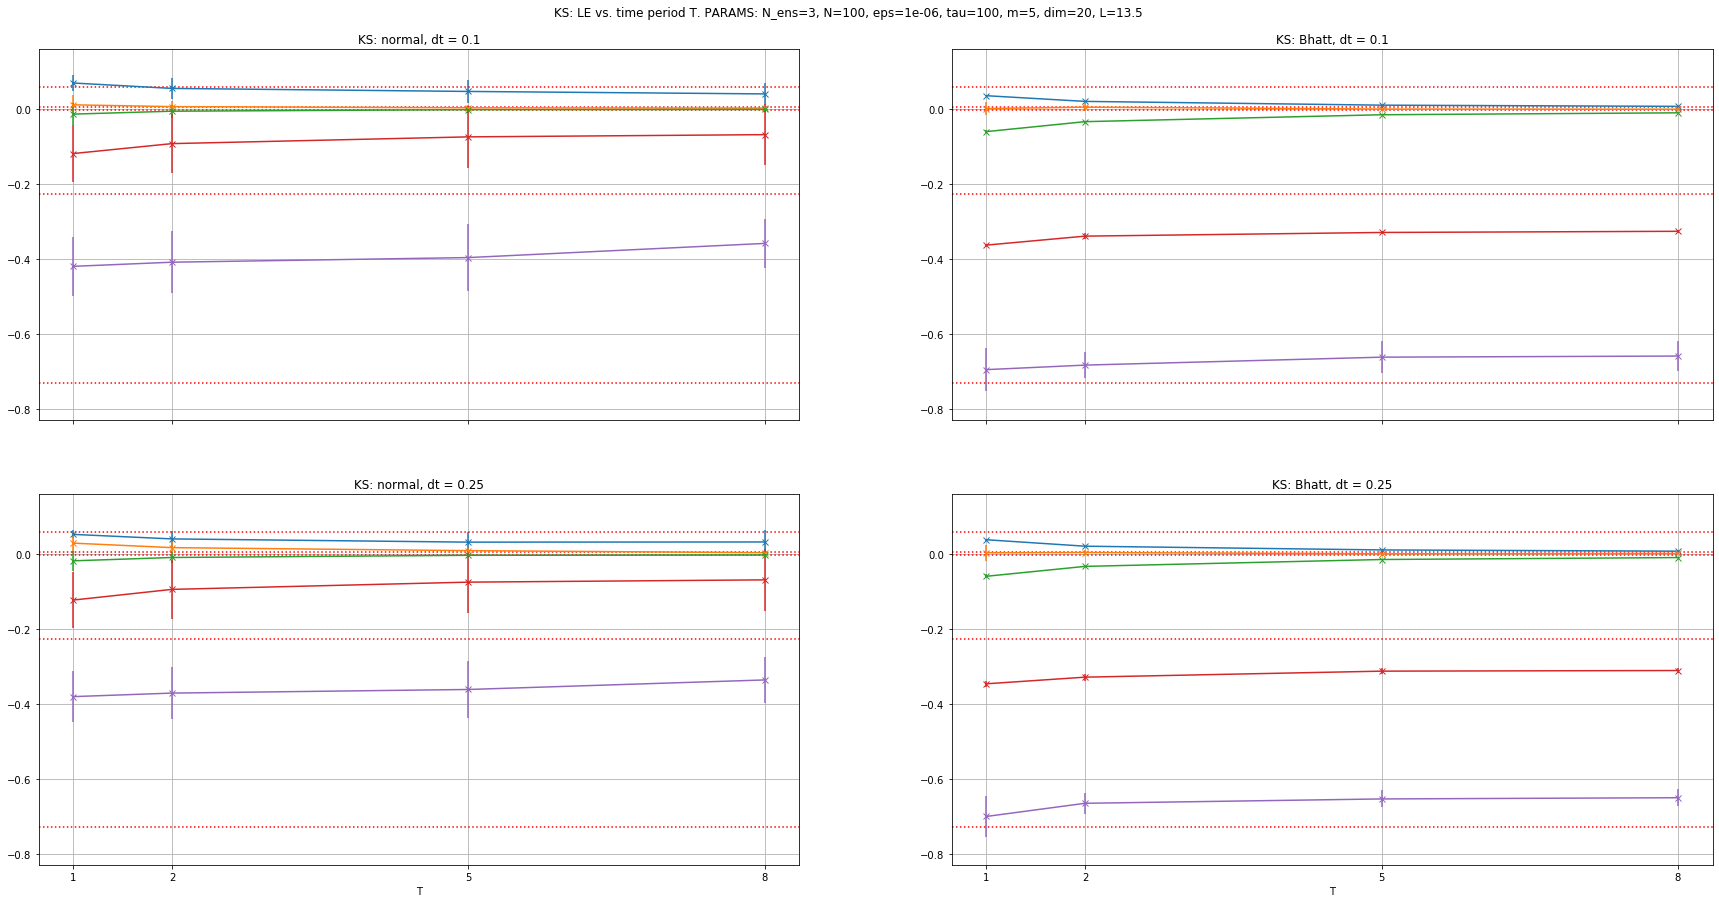

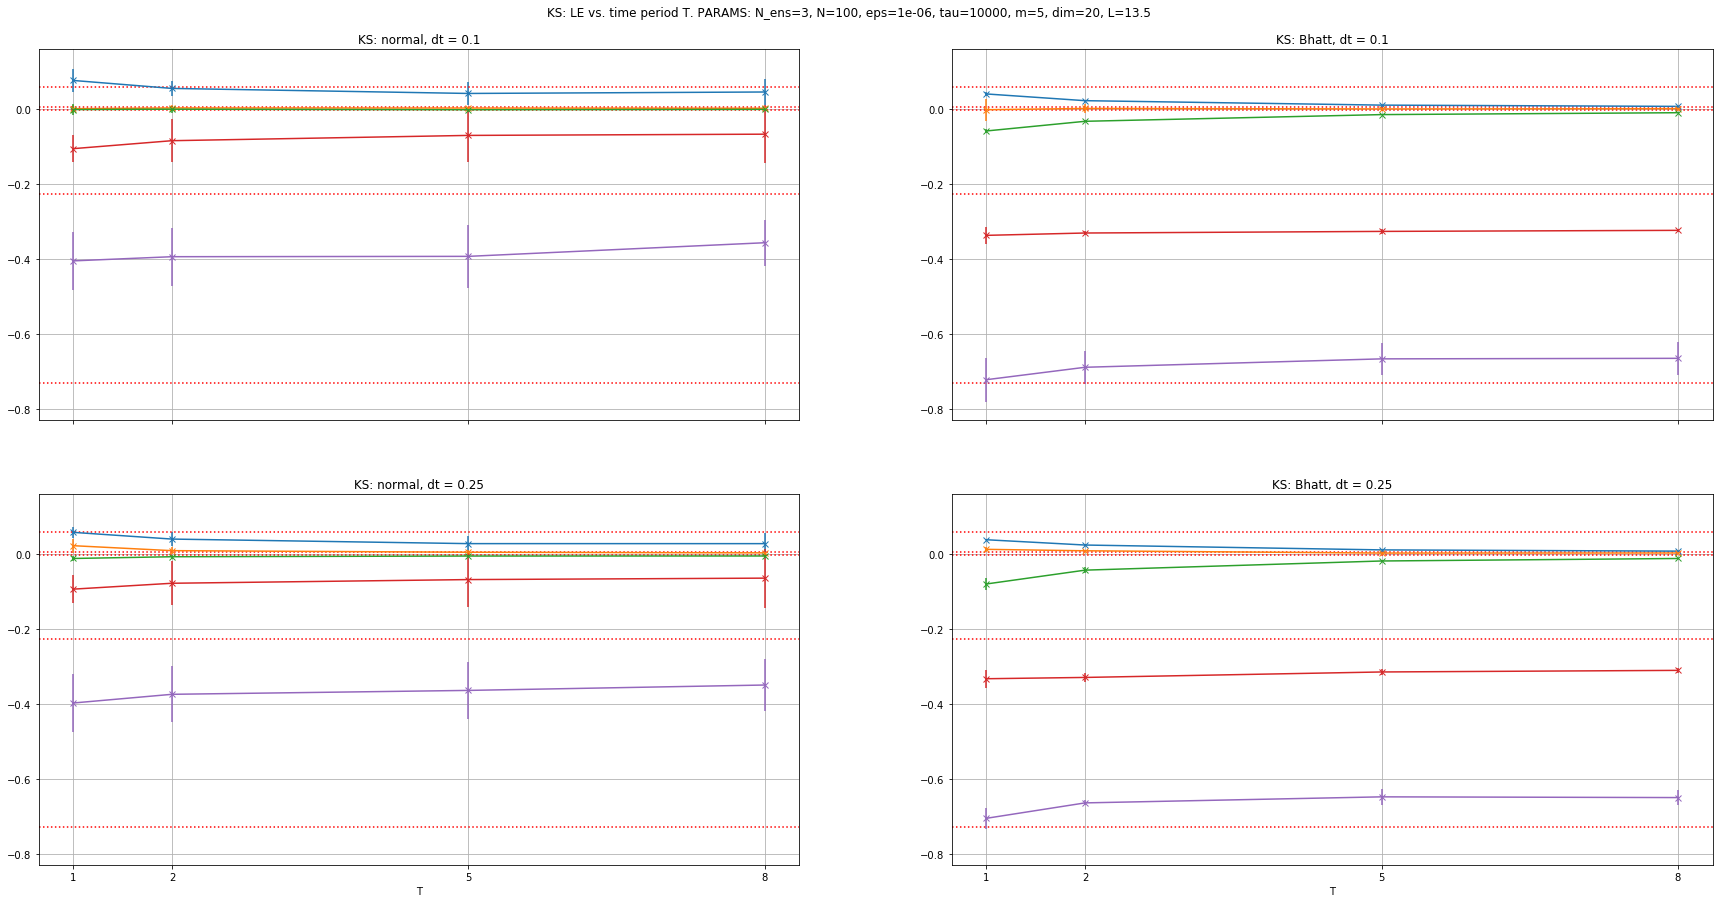

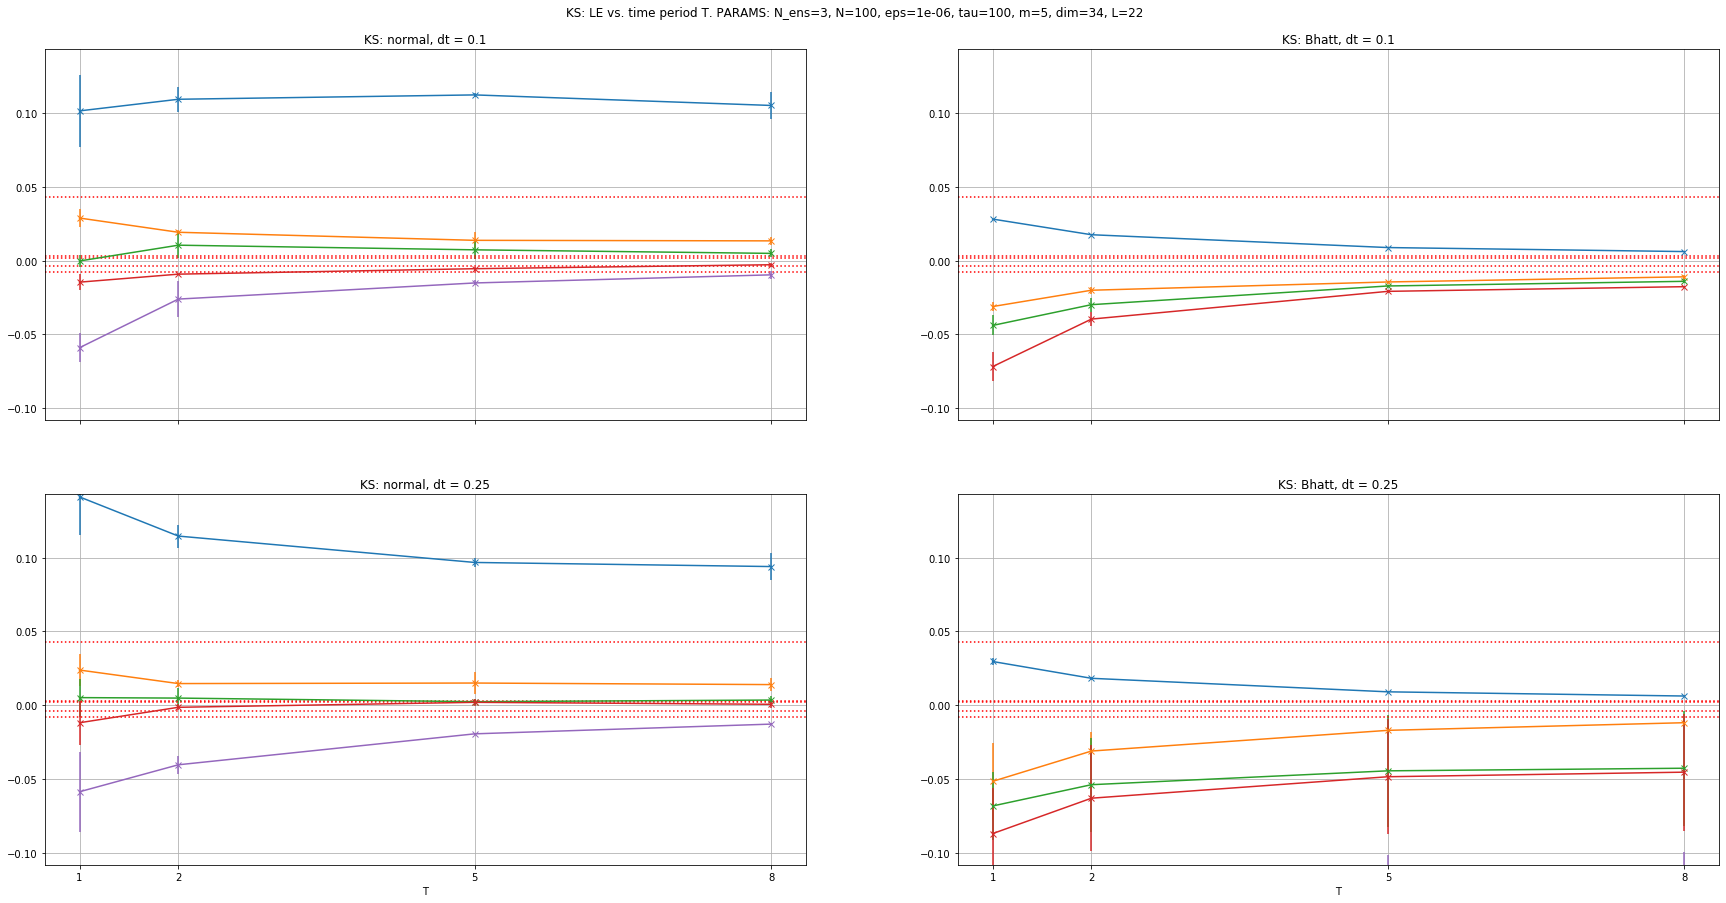

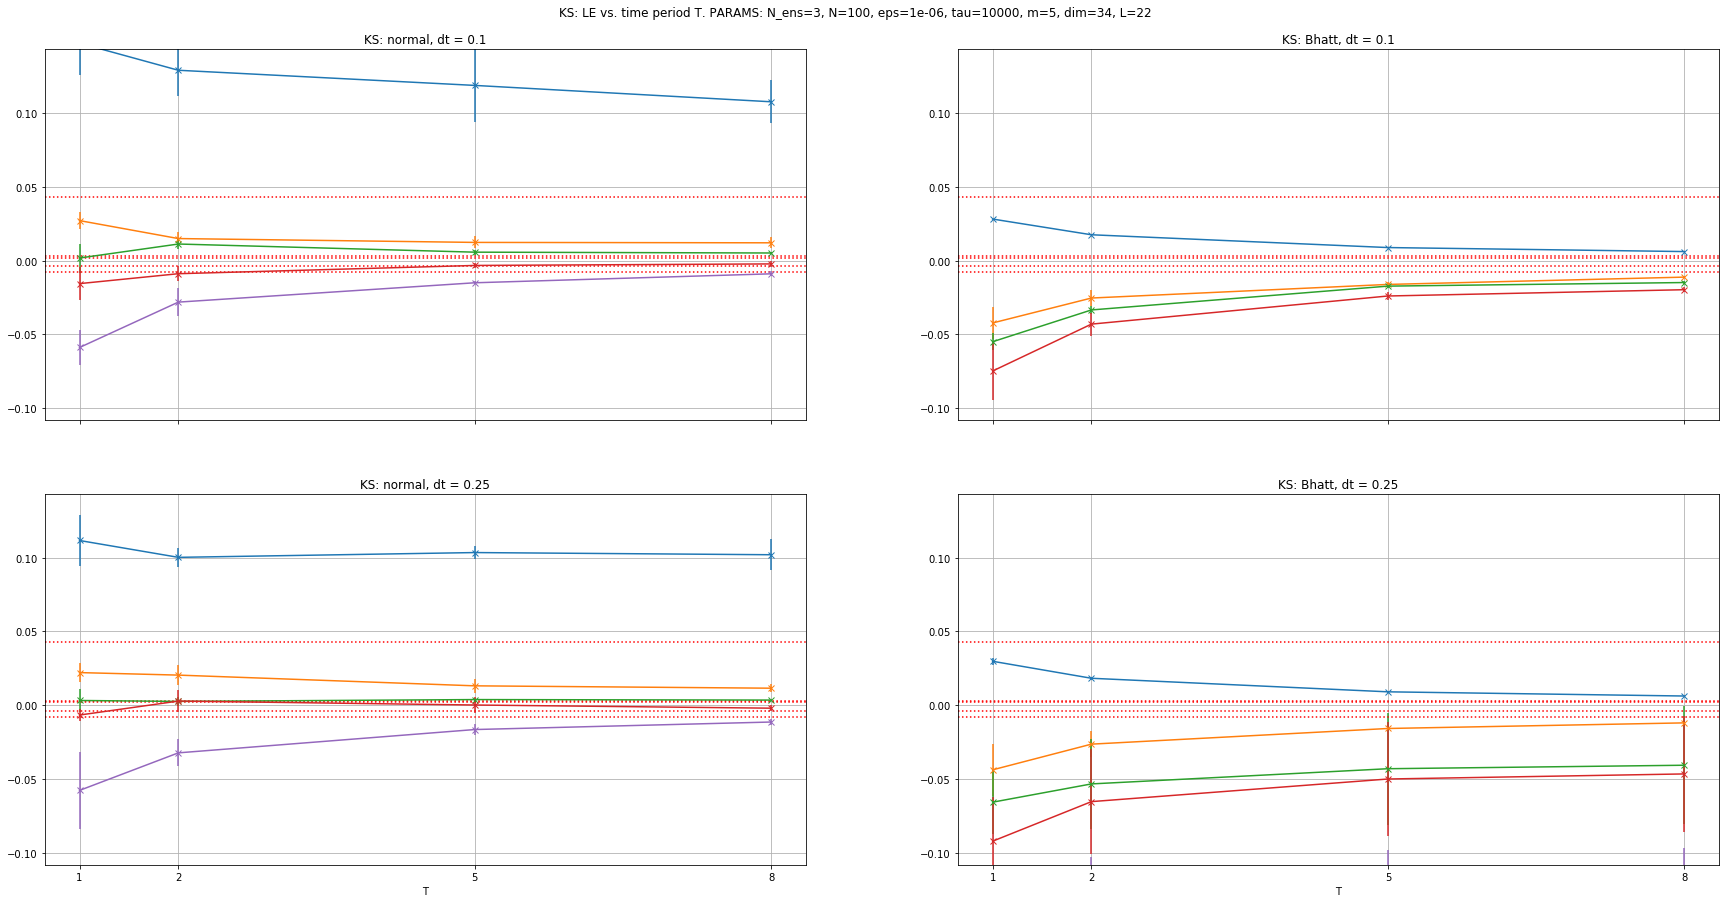

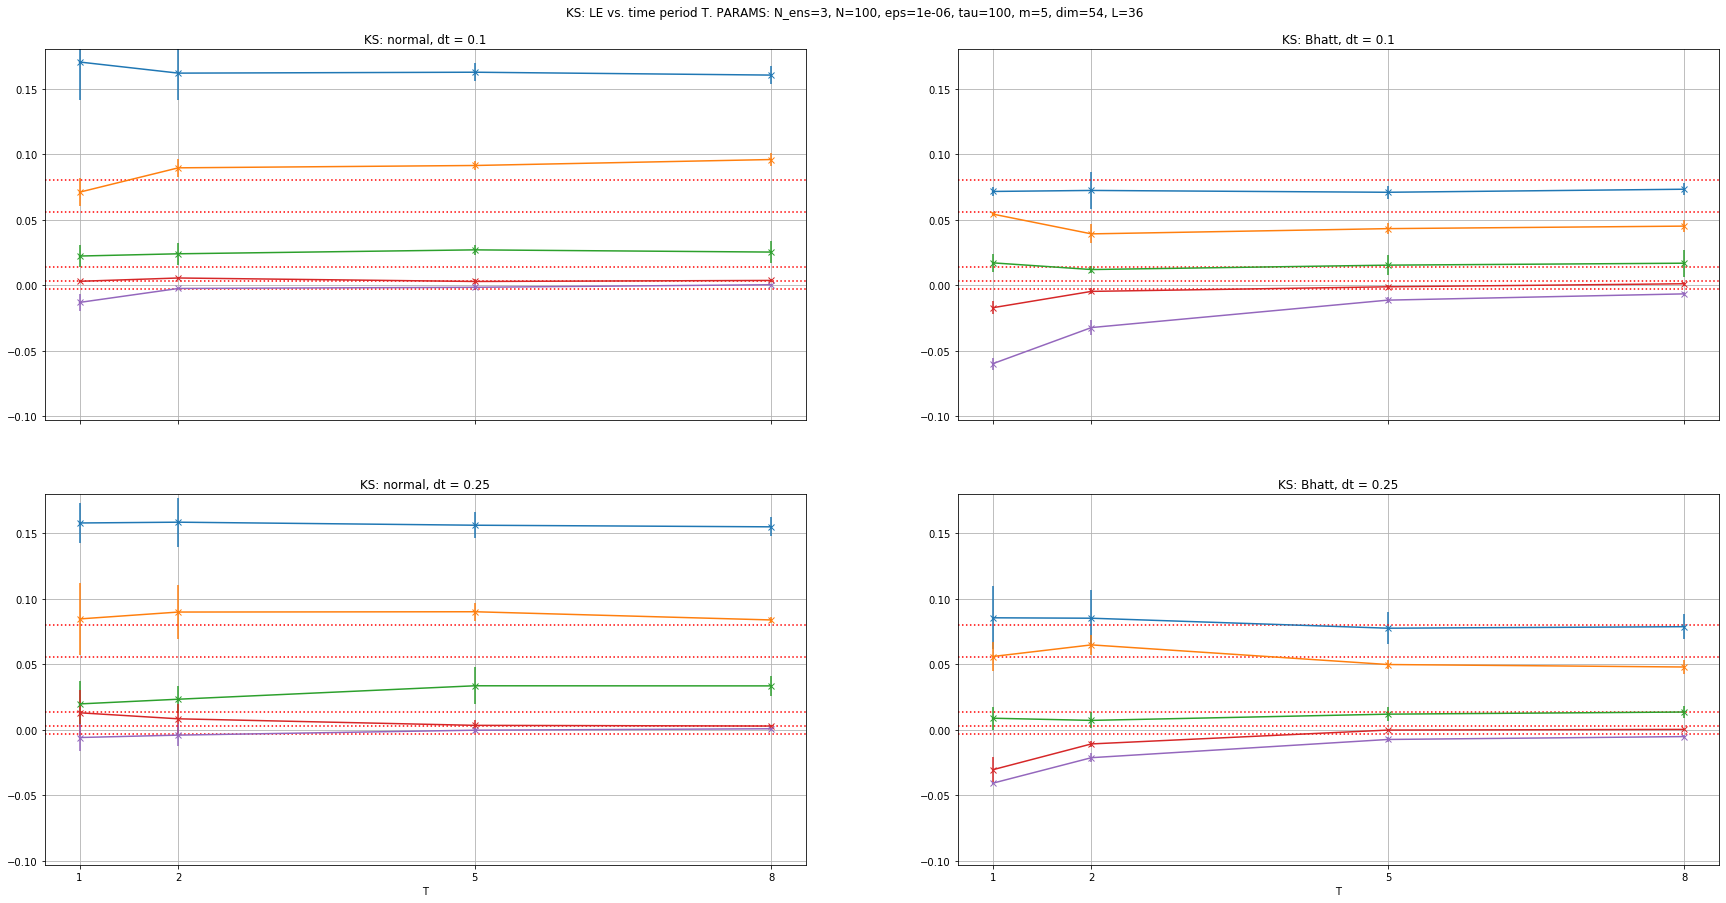

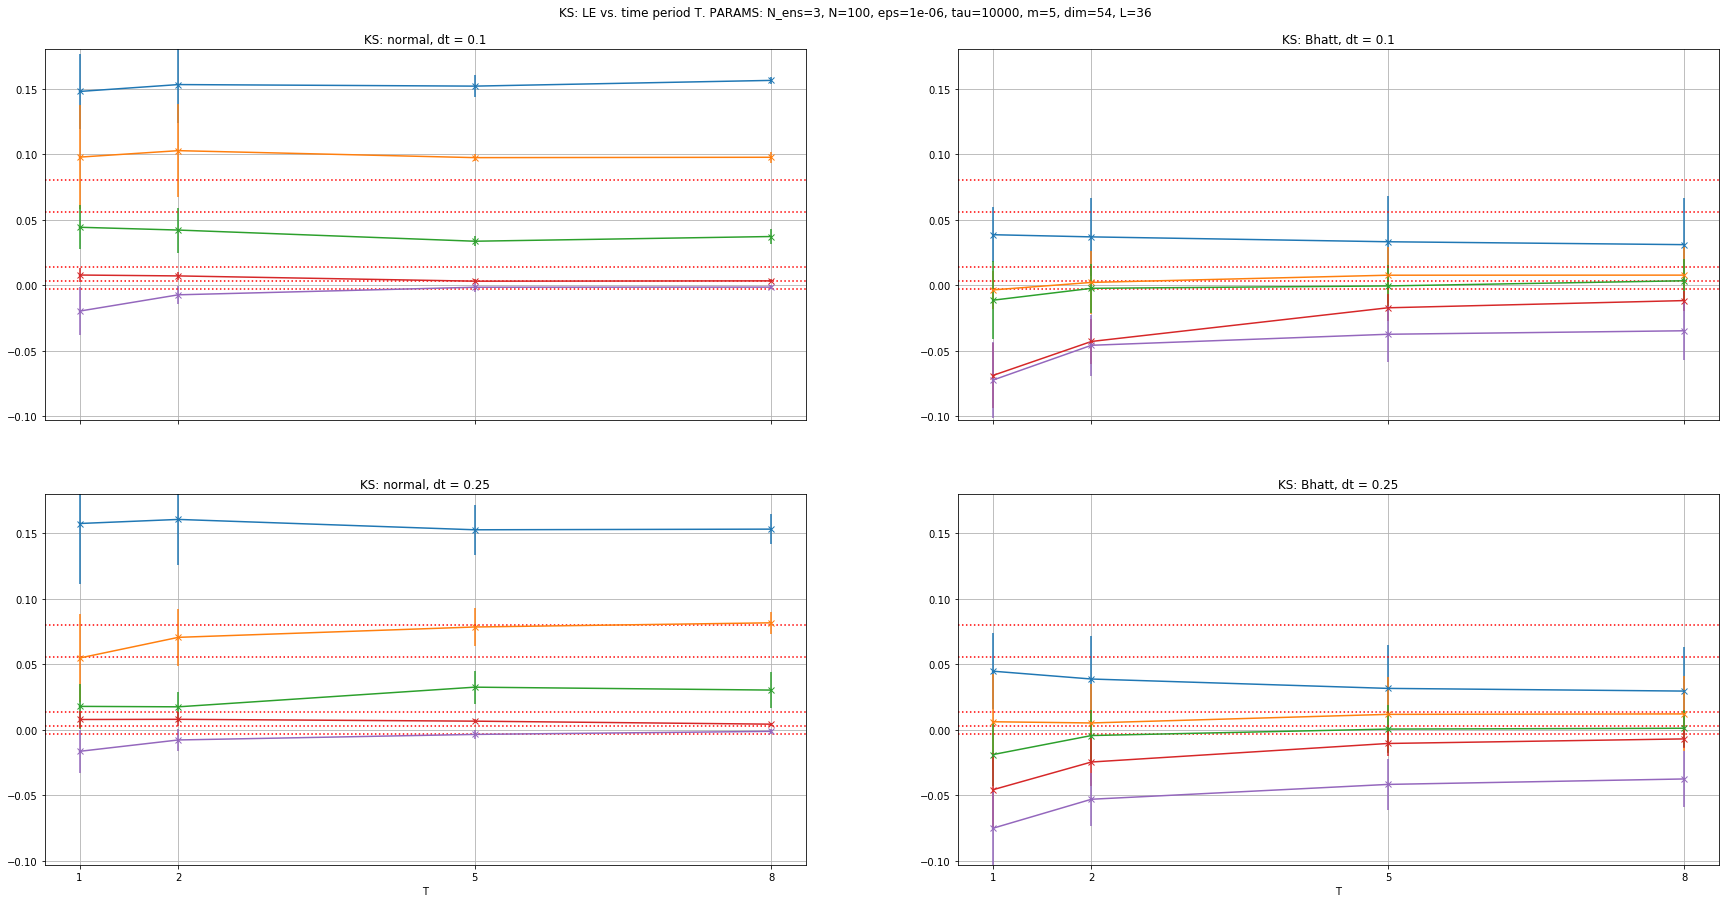

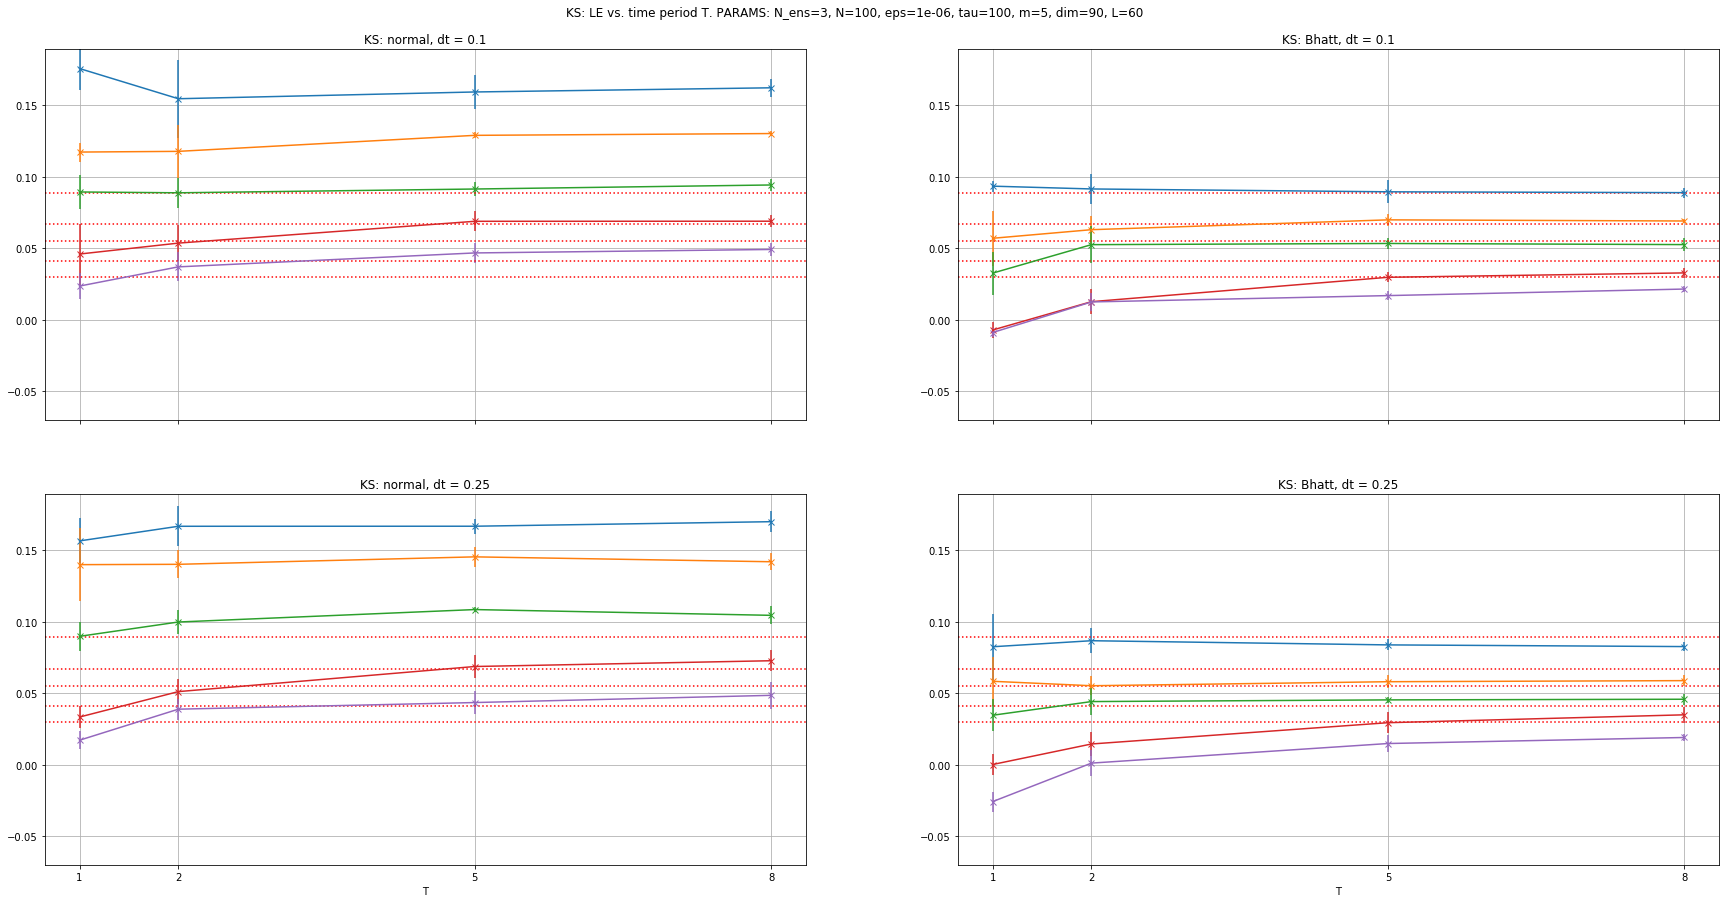

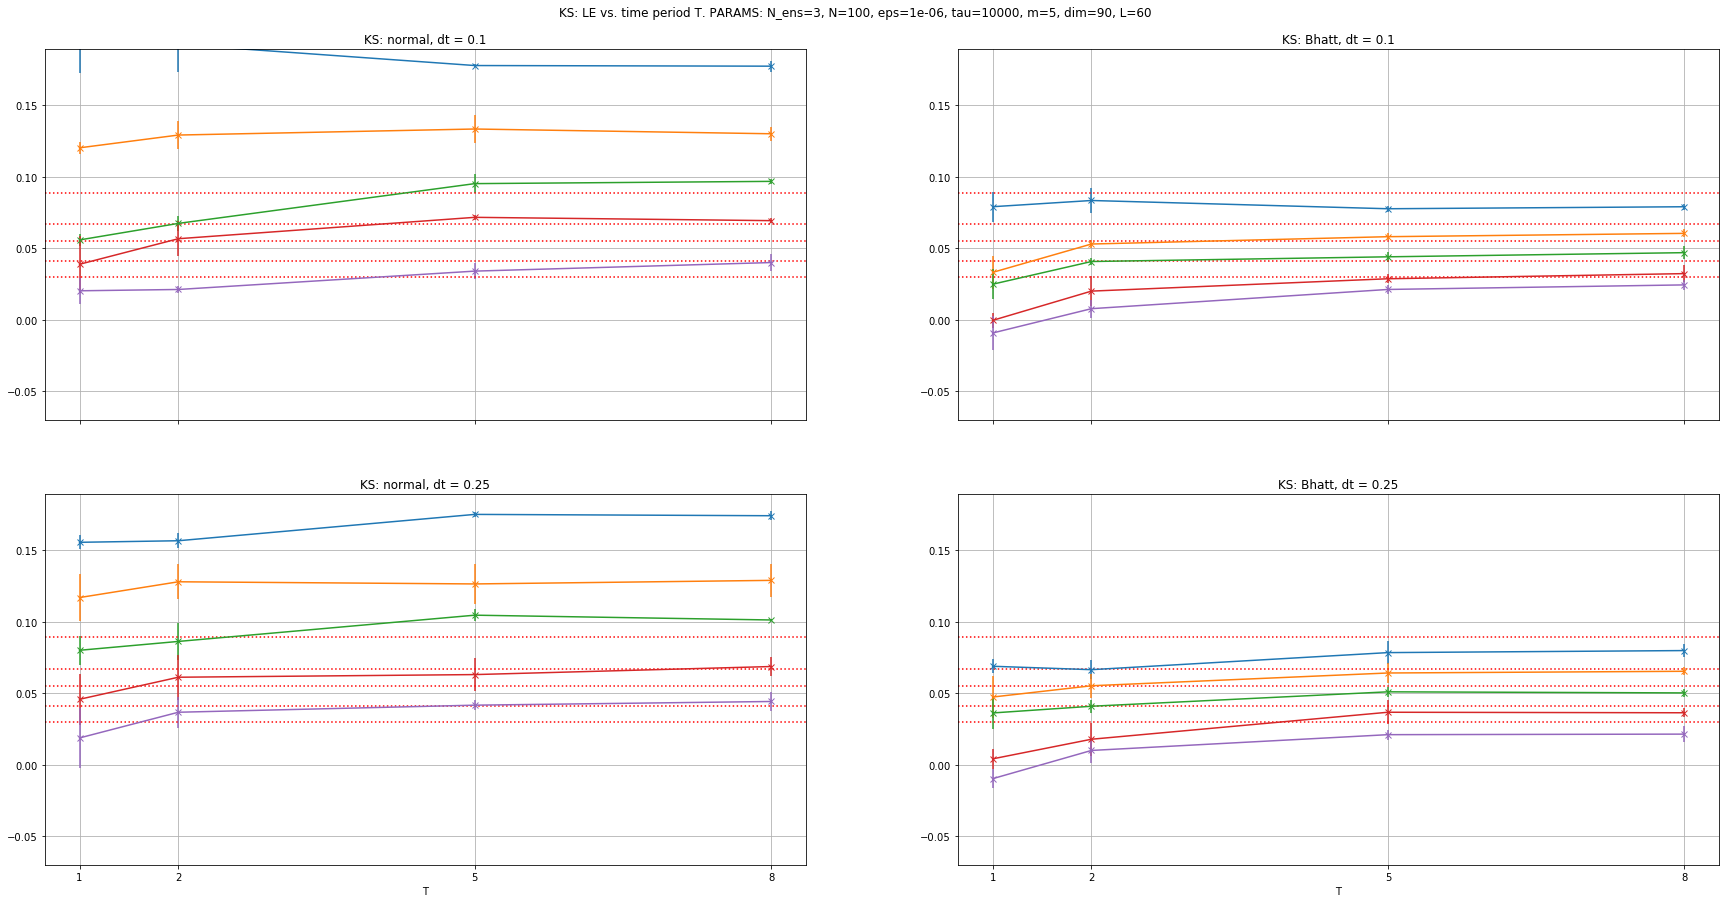

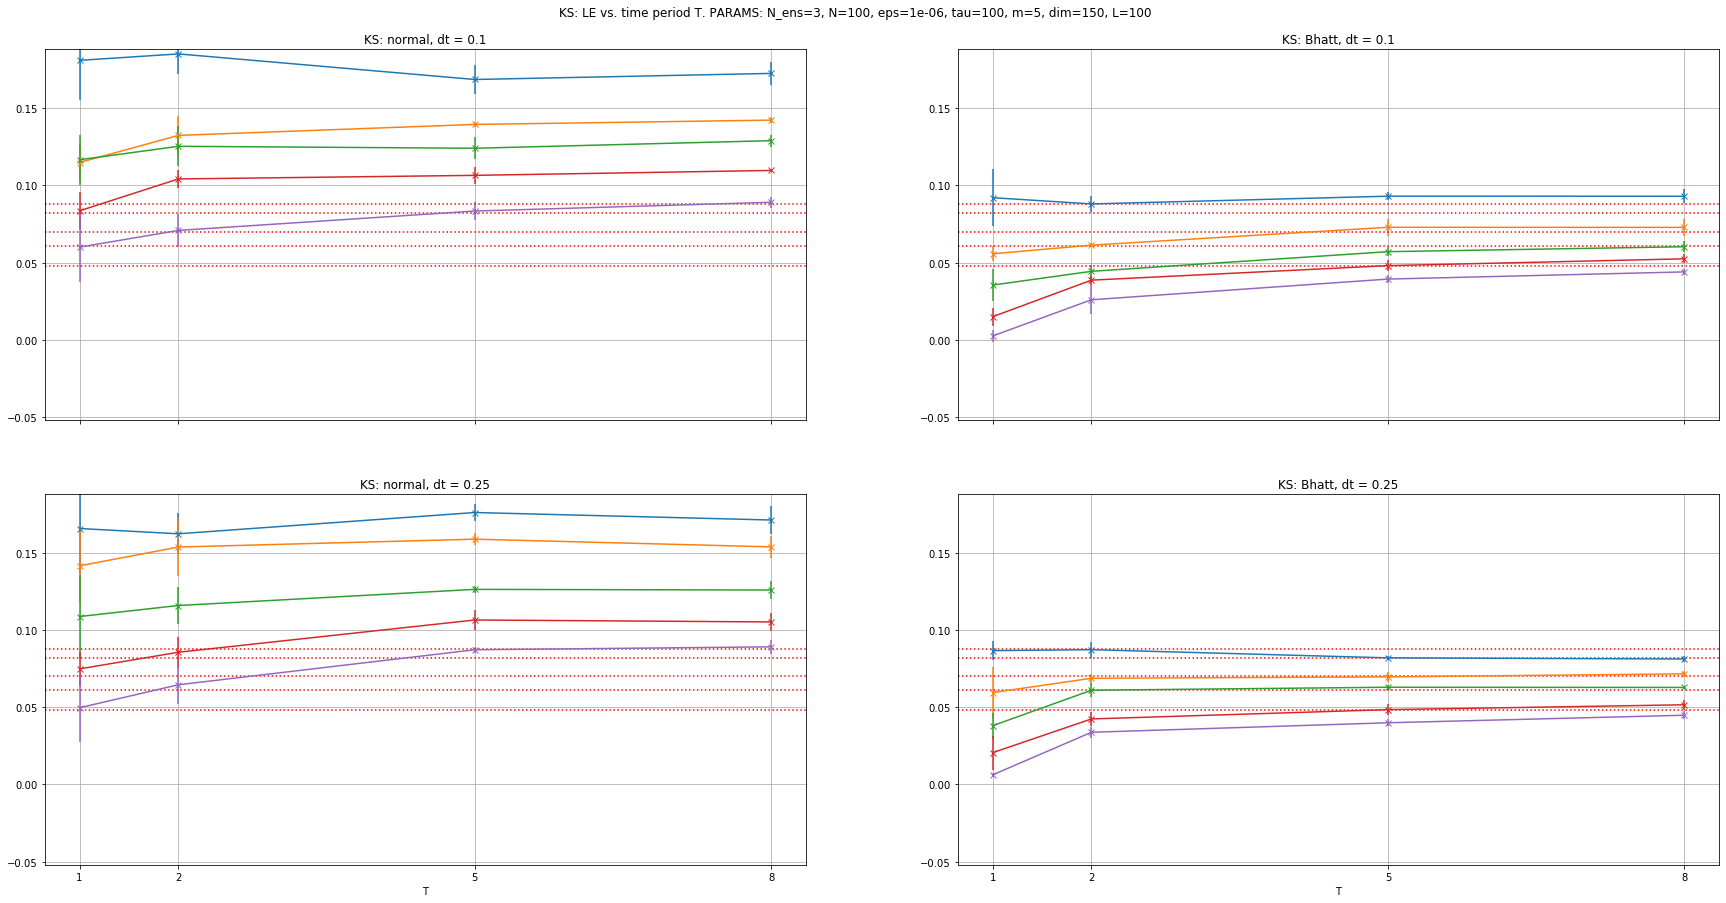

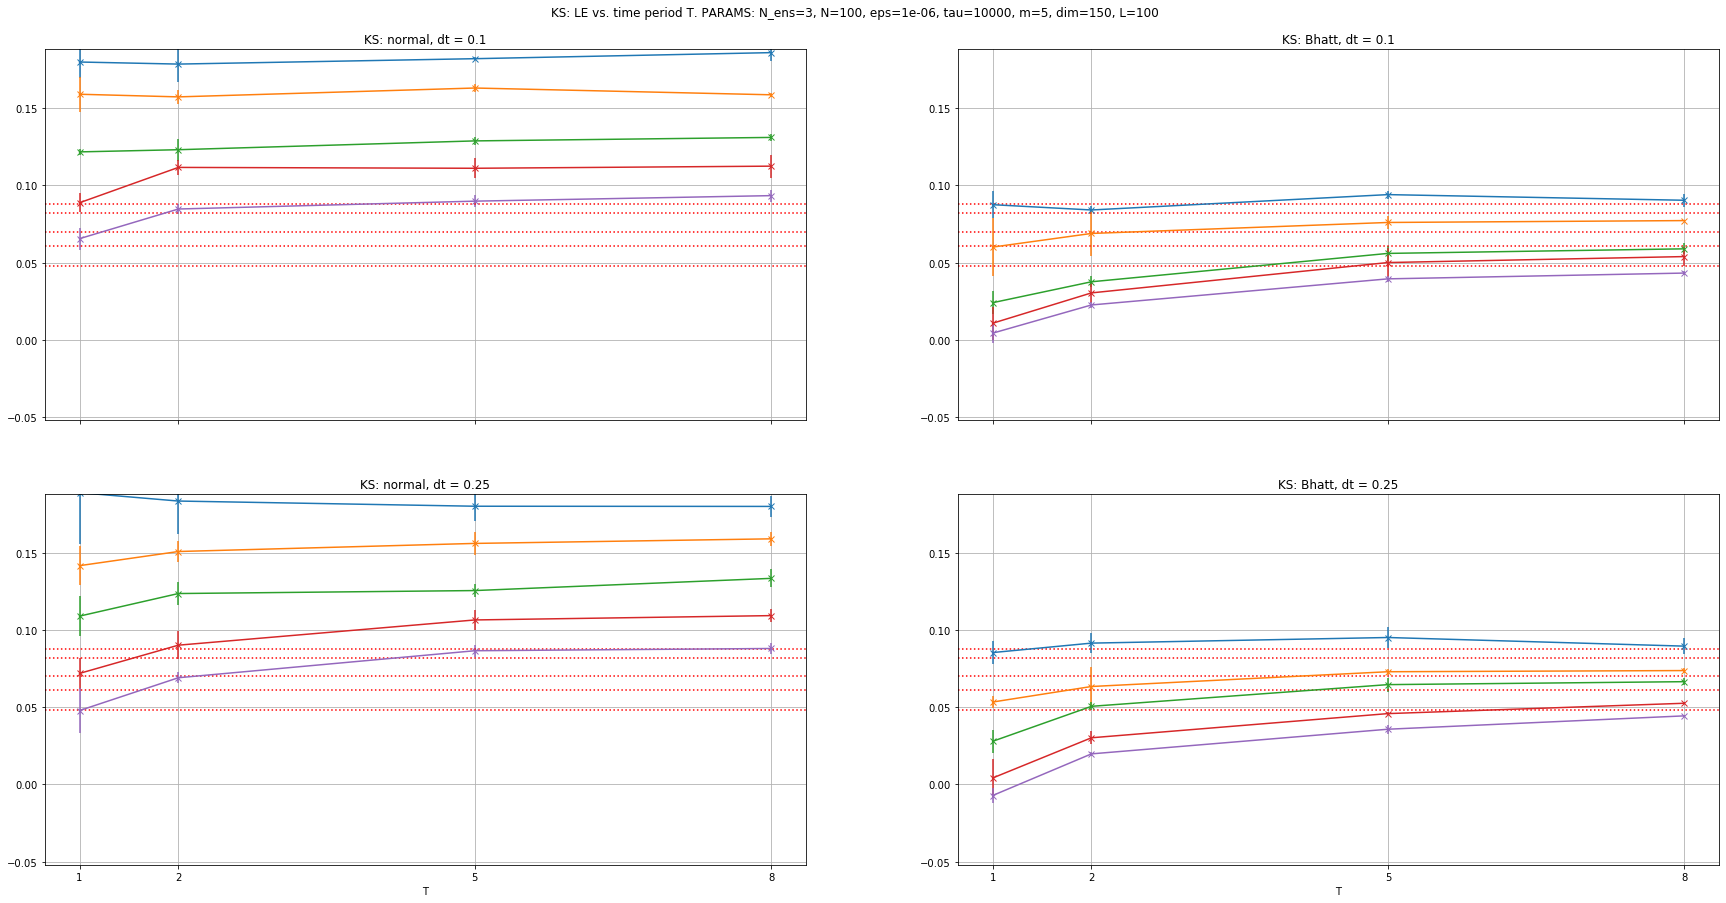

In [6]:
for i_sys, system_size in enumerate(system_sizes):
    print(f"system_size={system_size}")
    for i_tau, tau in enumerate(taus):
        print(f"tau={tau}")
        np.random.seed(1)
        
        lyapunov_exp_literature = LE_literature_dict[system_size]
        
        dimensions = int(system_size*ratio_dim_to_L)
        if dimensions%2 == 1: # for the fft KS sims, the dimension has to be even
            dimensions += 1 
        print(f"dimensions={dimensions}")
        
        starting_points = np.random.randn(N_ens, dimensions)
        
        ks_sim_dict = create_ks_sim_dict(dimensions, system_size)
        
        # calculation:
        results = np.zeros((N_ens, len(KS_sims), len(dts), len(Ts), m))

        for i_KS, KS_sim in enumerate(KS_sims):
            print(f"KS_sim: {KS_sim}")

            data_creation_function = ks_sim_dict[KS_sim]

            for i_dt, dt in enumerate(dts):
                print(f"dt: {dt}")

                def f(x):
                    return data_creation_function(time_steps=2, dt=dt, starting_point=x)[-1]

                for i_T, T in enumerate(Ts):
                    # print(f"T: {T}")

                    for i_st, starting_point in enumerate(starting_points):
                        lyaps = rescomp.measures.iterator_based_lyapunov_spectrum(f, 
                                                                     starting_point, 
                                                                     T=T, 
                                                                     tau=tau,
                                                                     eps=eps, 
                                                                     nr_steps=N, 
                                                                     dt=dt, 
                                                                     return_convergence=False,
                                                                     nr_of_lyapunovs=m,
                                                                     jacobian=None)
                        results[i_st, i_KS, i_dt, i_T, :] = lyaps
        
        # plotting:
#         y_lim = (-0.6, 0.6)
        y_lim = (min(lyapunov_exp_literature[:m]) - 0.1, max(lyapunov_exp_literature[:m]) + 0.1)

        fig, axs = plt.subplots(len(dts), len(KS_sims), figsize=(30,15), sharex=True)
        plt.suptitle(f"KS: LE vs. time period T. PARAMS: N_ens={N_ens}, N={N}, eps={eps}, tau={tau}, m={m}, dim={dimensions}, L={system_size}"
                     , y = 0.92)

        for i_ks, ks_sim in enumerate(KS_sims):
            for i_dt, dt in enumerate(dts):
                ax = axs[i_dt, i_ks]

                mean = results[:, i_ks, i_dt, :, :].mean(axis=0)
                std = results[:, i_ks, i_dt, :, :].std(axis=0)
                for i in range(m):
                    ax.errorbar(x=Ts, y=mean[:, i], yerr=std[:, i], fmt="-x")
                ax.set_xticks(Ts)
                ax.set_title(f"KS: {ks_sim}, dt = {dt}")
                ax.grid()
                ax.set_ylim(*y_lim)
                for i, y in enumerate(lyapunov_exp_literature):
                    if i == 0:
                        ax.axhline(y, c="r", linestyle=":", label="literature")
                    else:
                        ax.axhline(y, c="r", linestyle=":")
                    if i+1 == m:
                        break
            ax.set_xlabel("T")
        
        plt.savefig(f"L_{system_size}_tau_{tau}.png")

### version 1 (just plot)

In [66]:
np.random.seed(1)

# PARAMETERS
N = 100
tau = 100
eps = 0.1# 1e-3
m = 5
system_size = 36
ratio_dim_to_L = 2.0 #1.5
dimensions = int(system_size*ratio_dim_to_L)
if dimensions%2 == 1: # for the fft KS sims, the dimension has to be even
    dimensions += 1 
print(f"dimensions={dimensions}")
N_ens = 3

# SWEEP
Ts = [1, 2, 5]
dts= [0.25]

KS_sims = ["normal", "Bhatt"]
# KS_sims = ["normal", "Bhatt", "scipy32", "scipy64", "numpy32", "numpy64"]
starting_points = np.random.randn(N_ens, dimensions)

# LITERATURE VALUES:
lyapunov_exp_literature = LE_literature_dict[system_size]

dimensions=72


In [67]:
ks_sim_dict = create_ks_sim_dict(dimensions, system_size)

results = np.zeros((N_ens, len(KS_sims), len(dts), len(Ts), m))

for i_KS, KS_sim in enumerate(KS_sims):
    print(f"KS_sim: {KS_sim}")
    
    data_creation_function = ks_sim_dict[KS_sim]

    for i_dt, dt in enumerate(dts):
        print(f"dt: {dt}")
        
        def f(x):
            return data_creation_function(time_steps=2, dt=dt, starting_point=x)[-1]
        
        for i_T, T in enumerate(Ts):
            print(f"T: {T}")
            
            for i_st, starting_point in enumerate(starting_points):
                lyaps = rescomp.measures.iterator_based_lyapunov_spectrum(f, 
                                                             starting_point, 
                                                             T=T, 
                                                             tau=tau,
                                                             eps=eps, 
                                                             nr_steps=N, 
                                                             dt=dt, 
                                                             return_convergence=False,
                                                             nr_of_lyapunovs=m,
                                                             jacobian=None)
                results[i_st, i_KS, i_dt, i_T, :] = lyaps

KS_sim: normal
dt: 0.25
T: 1
T: 2
T: 5
KS_sim: Bhatt
dt: 0.25
T: 1
T: 2
T: 5


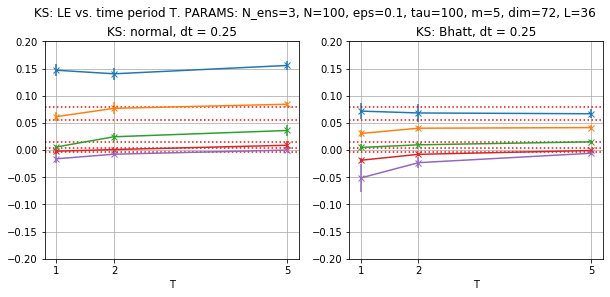

In [68]:
# PLOTTING

y_lim = (-0.2, 0.2)

fig, axs = plt.subplots(len(dts), len(KS_sims), figsize=(10,4), sharex=True)
plt.suptitle(f"KS: LE vs. time period T. PARAMS: N_ens={N_ens}, N={N}, eps={eps}, tau={tau}, m={m}, dim={dimensions}, L={system_size}"
             , y = 1.0)

for i_ks, ks_sim in enumerate(KS_sims):
    for i_dt, dt in enumerate(dts):
        if len(dts) == 1:
            if len(KS_sims) == 1:
                ax = axs
            else:
                ax = axs[i_ks]
        else:
            if len(KS_sims) == 1:
                ax = axs[i_dt]
            else:
                ax = axs[i_dt, i_ks]
        # ax = axs[i_dt, i_ks]
        mean = results[:, i_ks, i_dt, :, :].mean(axis=0)
        std = results[:, i_ks, i_dt, :, :].std(axis=0)
        for i in range(m):
            ax.errorbar(x=Ts, y=mean[:, i], yerr=std[:, i], fmt="-x")
        ax.set_xticks(Ts)
        ax.set_title(f"KS: {ks_sim}, dt = {dt}")
        ax.grid()
        ax.set_ylim(*y_lim)
        for i, y in enumerate(lyapunov_exp_literature):
            if i == 0:
                ax.axhline(y, c="r", linestyle=":", label="literature")
            else:
                ax.axhline(y, c="r", linestyle=":")
            if i+1 == m:
                break
    ax.set_xlabel("T")

### largest LE comparison:

In [80]:
np.random.seed(1)

# PARAMETERS
dt = 0.5
N = 1
tau = 1000
T = 100
eps = 1e-12
m = 1
system_size = 22 # 12, 13.5, 22, 36, 60, 100

# ratio_dim_to_L = 1.5
# dimensions = int(system_size*ratio_dim_to_L)
# if dimensions%2 == 1: # for the fft KS sims, the dimension has to be even
#     dimensions += 1 
dimensions = 40
print(f"dimensions={dimensions}")

# dimensions = 39
N_ens = 1

KS_sims = ["normal", "Bhatt", "scipy", "scipy32", "scipy64", "numpy", "numpy32", "numpy64"]
KS_sims = ["normal"]
# KS_sims = ["normal", "Bhatt", "scipy32"]
# KS_sims = ["Bhatt", ]

starting_points = np.random.randn(N_ens, dimensions)

# LITERATURE VALUES:
# lyapunov_exp_literature = [0.08, 0.056, 0.014, 0.003, -0.003, -0.004, -0.021, -0.088, -0.160, -0.224, -0.309, -0.373]
lyapunov_exp_literature = LE_literature_dict[system_size]

dimensions=40


In [81]:
results_LE_dev = {}
ks_sim_dict = create_ks_sim_dict(dimensions, system_size)
for key in KS_sims:
    data_creation_function = ks_sim_dict[key]
    print(f"ks sim type: {key}")
    results = np.zeros((N_ens, N, m))
    for i in range(N_ens):
        starting_point = starting_points[i, :]
        def f(x):
            return data_creation_function(time_steps=2, dt=dt, starting_point=x)[-1]
        out = rescomp.measures.iterator_based_lyapunov_spectrum(f, starting_point=starting_point, 
                                                                T=T, tau=tau, eps=eps, 
                                                                nr_steps=N, dt=dt, return_convergence=True, 
                                                                nr_of_lyapunovs=m)
        results[i, :, :] = out[1]
        results_LE_dev[key] = results

ks sim type: normal


In [82]:
results_LE_dev

{'normal': array([[[0.08027039]]])}

### older:

In [6]:
result = np.zeros((N_ens, N, m))

np.random.seed(5)
for n in range(N_ens):
    print(f"n: {n+1}")

    initial_condition = np.random.randn(dimensions)
    data_creation_function_KS = create_ks_sim_func(None, None, dimensions, system_size, mode="Bhatt")

    def f(x):
        return data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]

    # f = lambda x: data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]

    out = rescomp.measures.iterator_based_lyapunov_spectrum(f, starting_point=initial_condition, T=T, tau=tau, eps=eps, 
                                              nr_steps=N, dt=dt, return_convergence=True, nr_of_lyapunovs=m)
    result[n, :, :] = out[1]

n: 1
n: 2
n: 3


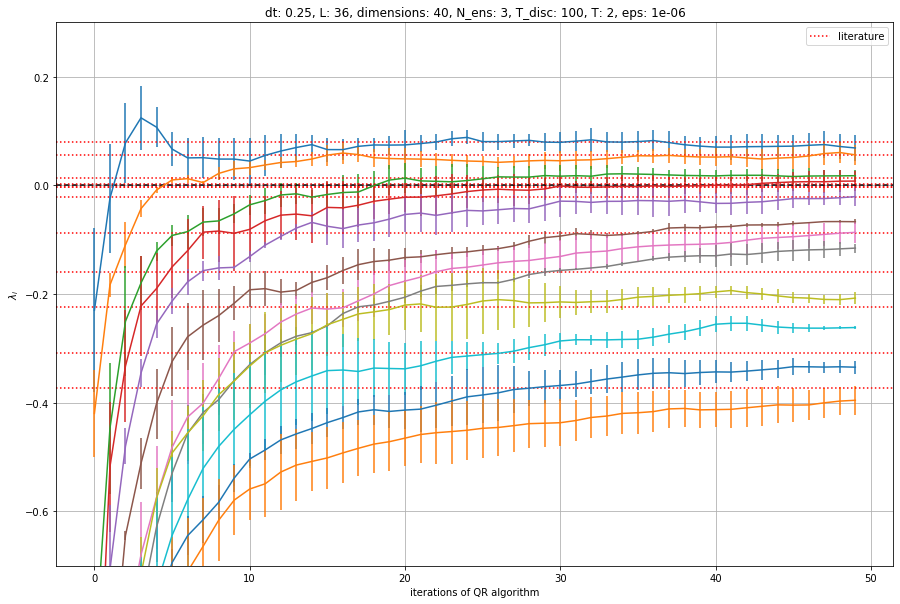

In [13]:
plt.figure(figsize=(15,10))

plt.title(f"dt: {dt}, L: {system_size}, dimensions: {dimensions}, N_ens: {N_ens}, T_disc: {tau}, T: {T}, eps: {eps}")
plt.grid()
# avg = result.mean(axis=0)
error = result.std(axis=0)
avg = result[3, :]

for dim in range(m):
    plt.errorbar(x=np.arange(N), y=avg[:, dim], yerr=error[:, dim])
plt.xlabel("iterations of QR algorithm")
plt.ylabel(r"$\lambda_i$")
plt.axhline(0, c="k", linestyle ="--")
for i, y in enumerate(lyapunov_exp_literature):
    if i == 0:
        plt.axhline(y, c="r", linestyle=":", label="literature")
    else:
        plt.axhline(y, c="r", linestyle=":")
plt.ylim(-0.7, 0.3)
plt.legend()

### KS System:

In [ ]:
# KS system:
dimensions = 40
system_size = 30
def data_creation_function_KS(time_steps, dt, starting_point=None):
    sim_data = rescomp.simulate_trajectory(
            sys_flag='kuramoto_sivashinsky', dimensions=dimensions, system_size=system_size, dt=dt,
            time_steps=time_steps, starting_point = starting_point)
    return sim_data

def data_creation_function_KS_Bhatt(time_steps, dt, starting_point=None):
    sim_data = rescomp.simulations._kuramoto_sivashinsky_Bhatt(dimensions=dimensions, system_size=system_size, dt=dt,
                                                    time_steps=time_steps, starting_point=starting_point,
                                                    alpha=1, beta=1)
    return sim_data

In [ ]:
dt = 0.1
N = 100
tau = 5
T = 2
eps = 1e-6
m = 12

In [ ]:
same_starting_point = data_creation_function_KS(time_steps=1, dt=1, starting_point=None)[-1]

f1 = lambda x: data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]
f2 = lambda x: data_creation_function_KS_Bhatt(time_steps=2, dt=dt, starting_point=x)[-1]

In [ ]:
# original KS Sim:
lyapunov_exp, lyapunov_exp_convergence = rescomp.measures.iterator_based_lyapunov_spectrum(f1, 
                                                                                           starting_point=same_starting_point, 
                                                                                           T=T, 
                                                                                           tau=tau,
                                                  eps=eps, nr_steps=N, dt=dt, return_convergence=True, nr_of_lyapunovs=m)

In [ ]:
# Bhatt KS Sim:
lyapunov_exp_B, lyapunov_exp_convergence_B = rescomp.measures.iterator_based_lyapunov_spectrum(f2, 
                                                                                               starting_point=same_starting_point,
                                                                                               T=T, 
                                                                                           tau=tau,
                                                  eps=eps, nr_steps=N, dt=dt, return_convergence=True, nr_of_lyapunovs=m)

In [ ]:
print(lyapunov_exp)
plt.figure(figsize=(10,5))
for iteration in lyapunov_exp_convergence.T:
    plt.plot(iteration[20:])
plt.grid()

In [ ]:
print(lyapunov_exp_B)
plt.figure(figsize=(10,5))
for iteration in lyapunov_exp_convergence_B.T:
    plt.plot(iteration[20:])
plt.grid()

In [ ]:
delta_exp = lyapunov_exp_B - lyapunov_exp
print(delta_exp)
plt.figure(figsize=(10,5))
for iteration in np.abs(lyapunov_exp_convergence_B - lyapunov_exp_convergence).T:
    plt.plot(iteration[20:])
plt.grid()

# Test _kuramoto_sivashinsky_custom

In [ ]:
# Sweep:
precisions = [128, 64, 32, 16]
fft_types = ["numpy", "scipy", "pyfftw_np", "pyfftw_sc", "pyfftw_fftw"]

# Fixed:
starting_point=None
dimensions = 40
system_size = 30

# LE-Algo:
dt = 0.1
N = 100
tau = 10
T = 5
eps = 1e-6
m = 12

def create_ks_sim_func(fft_type, prec, dimensions, system_size):
    def data_creation_function(time_steps, dt, starting_point=None):
        return rescomp.simulations._kuramoto_sivashinsky_custom(dimensions, system_size, dt, time_steps, starting_point,
                                 precision=prec, fft_type=fft_type)
    return data_creation_function
                                                        
data_creation_functions_dict = {}
for prec in precisions:
    for fft_type in fft_types:
        data_creation_functions_dict[(prec, fft_type)] = create_ks_sim_func(fft_type, prec, dimensions, system_size)

In [ ]:
res_dict = {}

i = 1
for key, func in data_creation_functions_dict.items():
    print(i, key)
    i+=1
    f = lambda x: func(time_steps=2, dt=dt, starting_point=x)[-1]
    try:
        lyapunov_exp_res = rescomp.measures.iterator_based_lyapunov_spectrum(f, 
                                                                             starting_point, 
                                                                             T=T, 
                                                                             tau=tau,
                                                                             eps=eps, 
                                                                             nr_steps=N, 
                                                                             dt=dt, 
                                                                             return_convergence=True,
                                                                             nr_of_lyapunovs=m)
        res_dict[key] = lyapunov_exp_res
    except Exception as e:
        print("Error: ", e)
        res_dict[key] = e
    

In [ ]:
plt.figure(figsize=(15,7))

for key, val in res_dict.items():
    if type(val) == tuple:
        largest_le_index = np.argmax(val[0])
        largest_le_evol = val[1][:, largest_le_index]
        if np.isnan(largest_le_evol).any():
            msg = "nan"
            print(f"{key}, {msg}")
        plt.plot(largest_le_evol, label=key)
    else:
        print(f"{key}, error: {val}")

print("____\n others:")
plt.title("Largest Lyapunov exponent, evolution")
plt.xlabel("iterations of QR algorithm")
plt.legend()
plt.grid()

# Test _kuramoto_sivashinsky_custom 2

In [ ]:
def KS_LEs_literature(m, L):
    '''
    Arxiv: 1902.09651
    not sure how good
    '''
    LEs = np.zeros(m)
    for i in range(m):
        LEs[i] = 0.093 - 0.94*((i+1)- 0.39)/L
    return LEs
LEs = KS_LEs_literature(m=12, L=10)

plt.grid()
plt.axhline(0, c="k", linestyle ="--")
for y in lyapunov_exp_literature:
    plt.axhline(y, c="r", linestyle=":")
for y in LEs:
    plt.axhline(y, c="b", linestyle=":")

In [ ]:
# system_size = 36

# LE_literature_dict = {12: [0.003, -0]}

lyapunov_exp_literature = [0.08, 0.056, 0.014, 0.003, -0.003, -0.004, -0.021, -0.088, -0.160, -0.224, -0.309, -0.373]
KY_literature = 8.229

dt = 0.25
N = 100
tau = 2000
T = 2
eps = 1e-6
m = 12
system_size = 36
dimensions = 60

In [ ]:
def create_ks_sim_func(fft_type, prec, dimensions, system_size):
    def data_creation_function(time_steps, dt, starting_point=None):
        return rescomp.simulations._kuramoto_sivashinsky_custom(dimensions, system_size, dt, time_steps, starting_point,
                                 precision=prec, fft_type=fft_type)
    return data_creation_function

In [ ]:
data_creation_function_KS = create_ks_sim_func(fft_type="scipy", prec=32, dimensions=dimensions, system_size=system_size)

f = lambda x: data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]


In [ ]:
np.random.seed(1)
initial_condition = np.random.randn(dimensions)
# initial_condition = None

out = rescomp.measures.iterator_based_lyapunov_spectrum(f, starting_point=initial_condition, T=T, tau=tau, eps=eps, 
                                                  nr_steps=N, dt=dt, return_convergence=True, nr_of_lyapunovs=m)

In [ ]:
lyaps, lyaps_development = out

title = "KS, 12 most positive LEs, scipy 64"
plt.figure(figsize=(15, 10))

plt.title(title)
plt.xlabel("iterations of QR algorithm")
plt.ylabel(r"$\lambda_i$")
plt.plot(lyaps_development[:, :12])
plt.grid()
plt.axhline(0, c="k", linestyle ="--")
for i, y in enumerate(lyapunov_exp_literature):
    if i == 0:
        plt.axhline(y, c="r", linestyle=":", label="literature")
    else:
        plt.axhline(y, c="r", linestyle=":")

plt.legend()

In [ ]:
KY = rescomp.measures.KY_dimension(lyaps)
print(KY)

# check multiple initial conditions:

In [9]:
def create_ks_sim_func(fft_type, prec, dimensions, system_size, mode="normal"):
    if mode == "precision":
        def data_creation_function(time_steps, dt, starting_point=None):
            return rescomp.simulations._kuramoto_sivashinsky_custom(dimensions, system_size, dt, time_steps, starting_point,
                                     precision=prec, fft_type=fft_type)
    elif mode == "Bhatt":
        def data_creation_function(time_steps, dt, starting_point=None):
            return rescomp.simulations._kuramoto_sivashinsky_Bhatt(dimensions, system_size, dt, time_steps, starting_point)
    elif mode == "normal":
        def data_creation_function(time_steps, dt, starting_point=None):
            return rescomp.simulations._kuramoto_sivashinsky(dimensions, system_size, dt, time_steps, starting_point)
    
    return data_creation_function



In [53]:
lyapunov_exp_literature = [0.08, 0.056, 0.014, 0.003, -0.003, -0.004, -0.021, -0.088, -0.160, -0.224, -0.309, -0.373]

# PARAMETERS
dt = 0.25
N = 50# 10
tau = 100
T = 2
eps = 1e-8
m = 12
system_size = 36
dimensions = 40

### KS Precision changes:

In [54]:
# %%timeit
N_ens = 3
precisions = [32, 64]

out_dict = {x:np.zeros((N_ens, N, m)) for x in precisions}
for prec in precisions:
    np.random.seed(5)
    print(f"prec: {prec}")
    for n in range(N_ens):
        print(f"n: {n+1}")
    
        initial_condition = np.random.randn(dimensions)
        data_creation_function_KS = create_ks_sim_func(fft_type="scipy", prec=prec, dimensions=dimensions, 
                                                       system_size=system_size, mode="precision")
        
        def f(x):
            return data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]
        
        # f = lambda x: data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]
        
        out = rescomp.measures.iterator_based_lyapunov_spectrum(f, starting_point=initial_condition, T=T, tau=tau, eps=eps, 
                                                  nr_steps=N, dt=dt, return_convergence=True, nr_of_lyapunovs=m)
        out_dict[prec][n, :, :] = out[1]

prec: 32
n: 1
n: 2
n: 3
prec: 64
n: 1
n: 2
n: 3


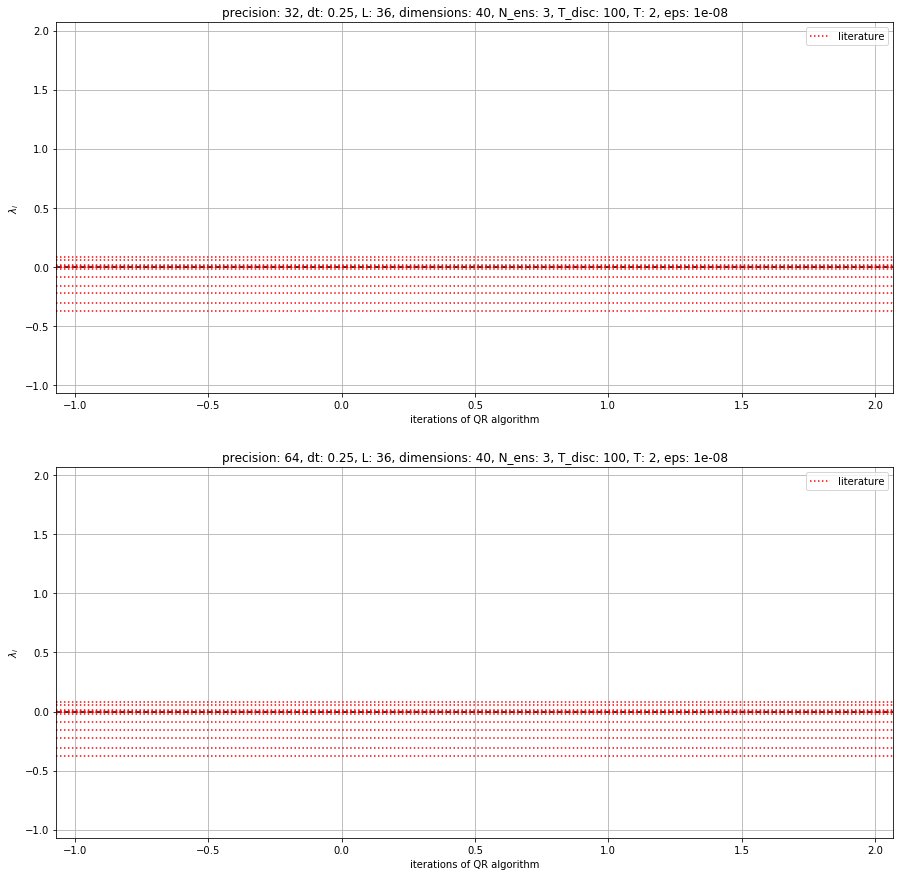

In [55]:
plt.figure(figsize=(15,15))

j = 0

for prec, val in out_dict.items():

    plt.subplot(2, 1, j+1)
    plt.title(f"precision: {prec}, dt: {dt}, L: {system_size}, dimensions: {dimensions}, N_ens: {N_ens}, T_disc: {tau}, T: {T}, eps: {eps}")
    plt.grid()
    avg = val.mean(axis=0)
    error = val.std(axis=0)
    for dim in range(m):
        plt.errorbar(x=np.arange(N), y=avg[:, dim], yerr=error[:, dim])
    plt.xlabel("iterations of QR algorithm")
    plt.ylabel(r"$\lambda_i$")
    plt.axhline(0, c="k", linestyle ="--")
    for i, y in enumerate(lyapunov_exp_literature):
        if i == 0:
            plt.axhline(y, c="r", linestyle=":", label="literature")
        else:
            plt.axhline(y, c="r", linestyle=":")
    
    plt.legend()
    j += 1

### Bhatt KS Simulation:

In [10]:
lyapunov_exp_literature = [0.08, 0.056, 0.014, 0.003, -0.003, -0.004, -0.021, -0.088, -0.160, -0.224, -0.309, -0.373]

# PARAMETERS
dt = 0.25
N = 100
tau = 1000
T = 2
eps = 1e-6
m = 12
system_size = 36
dimensions = 60

In [11]:
# %%timeit
N_ens = 3

result = np.zeros((N_ens, N, m))

np.random.seed(5)
for n in range(N_ens):
    print(f"n: {n+1}")

    initial_condition = np.random.randn(dimensions)
    data_creation_function_KS = create_ks_sim_func(None, None, dimensions, system_size, mode="Bhatt")

    def f(x):
        return data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]

    # f = lambda x: data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]

    out = rescomp.measures.iterator_based_lyapunov_spectrum(f, starting_point=initial_condition, T=T, tau=tau, eps=eps, 
                                              nr_steps=N, dt=dt, return_convergence=True, nr_of_lyapunovs=m)
    result[n, :, :] = out[1]

n: 1
n: 2
n: 3


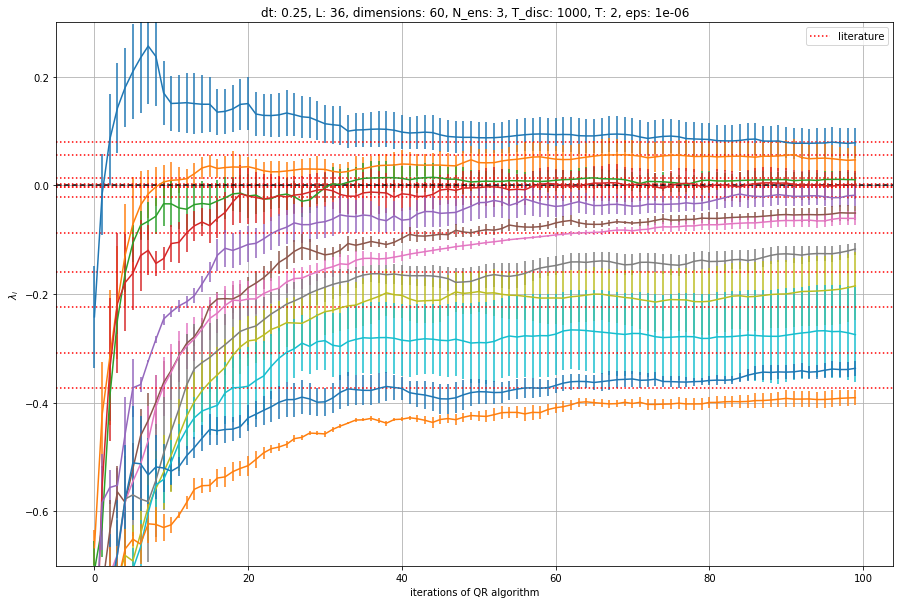

In [14]:
plt.figure(figsize=(15,10))

plt.title(f"dt: {dt}, L: {system_size}, dimensions: {dimensions}, N_ens: {N_ens}, T_disc: {tau}, T: {T}, eps: {eps}")
plt.grid()
avg = result.mean(axis=0)
avg = result[0, :]
error = result.std(axis=0)
for dim in range(m):
    plt.errorbar(x=np.arange(N), y=avg[:, dim], yerr=error[:, dim])
plt.xlabel("iterations of QR algorithm")
plt.ylabel(r"$\lambda_i$")
plt.axhline(0, c="k", linestyle ="--")
for i, y in enumerate(lyapunov_exp_literature):
    if i == 0:
        plt.axhline(y, c="r", linestyle=":", label="literature")
    else:
        plt.axhline(y, c="r", linestyle=":")
plt.ylim(-0.7, 0.3)
plt.legend()

### the "normal" KS Simulation:

In [58]:
# %%timeit
N_ens = 3

result = np.zeros((N_ens, N, m))

np.random.seed(5)
for n in range(N_ens):
    print(f"n: {n+1}")

    initial_condition = np.random.randn(dimensions)
    data_creation_function_KS = create_ks_sim_func(None, None, dimensions, system_size, mode="normal")

    def f(x):
        return data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]

    # f = lambda x: data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]

    out = rescomp.measures.iterator_based_lyapunov_spectrum(f, starting_point=initial_condition, T=T, tau=tau, eps=eps, 
                                              nr_steps=N, dt=dt, return_convergence=True, nr_of_lyapunovs=m)
    result[n, :, :] = out[1]

n: 1
n: 2
n: 3


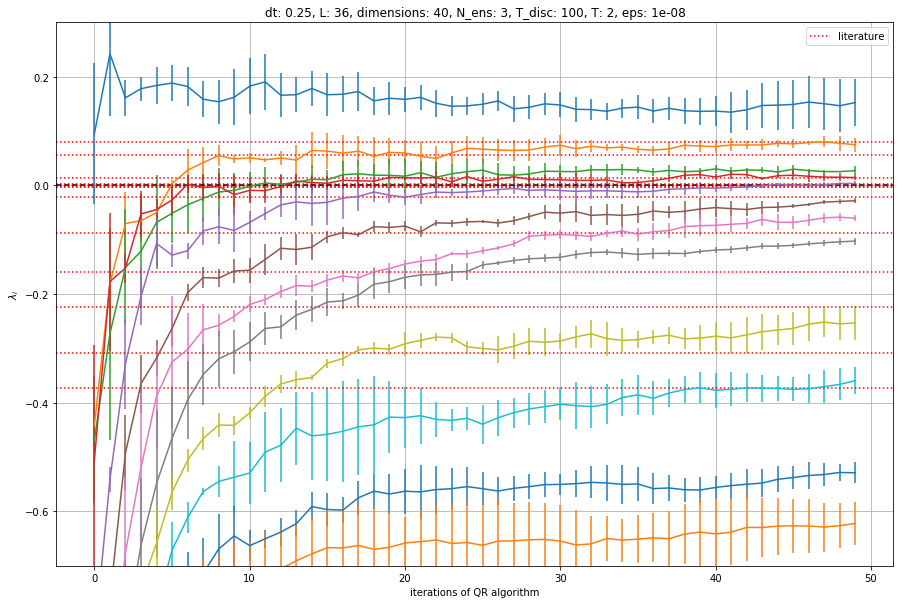

In [59]:
plt.figure(figsize=(15,10))

plt.title(f"dt: {dt}, L: {system_size}, dimensions: {dimensions}, N_ens: {N_ens}, T_disc: {tau}, T: {T}, eps: {eps}")
plt.grid()
avg = result.mean(axis=0)
error = result.std(axis=0)
for dim in range(m):
    plt.errorbar(x=np.arange(N), y=avg[:, dim], yerr=error[:, dim])
plt.xlabel("iterations of QR algorithm")
plt.ylabel(r"$\lambda_i$")
plt.axhline(0, c="k", linestyle ="--")
for i, y in enumerate(lyapunov_exp_literature):
    if i == 0:
        plt.axhline(y, c="r", linestyle=":", label="literature")
    else:
        plt.axhline(y, c="r", linestyle=":")
plt.ylim(-0.7, 0.3)
plt.legend()
